# Demo: How to Use pyGLMHMM

Here, we want to show the application of pyGLMHMM on some simulated data.

## Importing the required dependencies

We start importing the required dependencies for generating the simulated data and running the main program:

In [1]:
import numpy as np
import scipy.stats
import scipy.ndimage.filters
import matplotlib.pyplot as plt
from pyGLMHMM.GLMHMM import GLMHMMEstimator

## Setting the initial parameters of GLMHMMEstimator for num_sample = 1

An instance of 'GLMHMMEstimator' class must be generated with its different parameters. The most important ones are:

- num_samples: the number of distinct samples in the input data
- num_states: the number of hidden internal states
- num_emissions: the number of emitted behaviors or actions (like song types)
- num_feedbacks: the number of sensory feedback cues
- num_filter_bins: the number of bins to discretize the filters of sensory feedback cues
- num_steps: the number of steps taken in the maximization step of the EM algorithm for calculating the emission matrix
- filter_offset: the number of bias terms added to the sensory feedback cues

In [2]:
num_samples = 1
num_states = 2
num_emissions = 2
num_feedbacks = 3
num_filter_bins = 30
num_steps = 1
filter_offset = 1

## Initializing the simulation variables

In [3]:
tau = 4
total_time = 10000
noiseSD = 0.1
stim_scale = 1
num_real_states = 2

In [4]:
stim = []
states = []
output_stim = []
output_symb = []

## Generating random stimuli (sensory feedback cues)

In [5]:
stim_temp = np.zeros((num_filter_bins, total_time + num_filter_bins - 1, num_feedbacks))
stim_temp[0, :, :] = scipy.ndimage.filters.gaussian_filter(np.random.randn(total_time + num_filter_bins - 1, num_feedbacks), stim_scale)
    
for i in range(1, num_filter_bins):
    stim_temp[i, 0:total_time, :] = stim_temp[0, i:(total_time + i), :]
    
stim.append(stim_temp[:, 0:total_time, :] + np.random.randn(num_filter_bins, total_time, num_feedbacks) * noiseSD)

We concatenate the stimuli of all sensory feedback cues and augment it with bias or offset terms (with value '1') and generate the final 'output_stim' (X) variable: 

In [6]:
final_stim = np.append(stim[0][:, :, 0], stim[0][:, :, 1], axis = 0)
final_stim = np.append(final_stim, stim[0][:, :, 2], axis = 0)
final_stim = np.append(final_stim, np.ones((filter_offset, total_time)), axis = 0)
output_stim.append(final_stim)

## Generating a random filter which acts on behavior emissions and state transitions

The GLMâ€“HMM model allows each state to have an associated multinomial GLM or 'filter' to describe the mapping from feedback cues to the probability of emitting a particular type of behavior. Each state also has a multinomial GLM or 'filter' that produces a mapping from feedback cues to the transition probabilities from the current state to the next state. 

In [7]:
filt = scipy.stats.gamma.pdf(np.linspace(0, num_filter_bins), a = tau)[0:num_filter_bins]

The filter with positive (nagative) sign acts on the first (second) stimulus type or sensory feedback cue to determine the emission probability of the first type of behavior. Moreover, the filter with nagative (positive) sign acts on the first (second) stimulus type or sensory feedback cue to determine the emission probability of the second type of behavior. Also, the filter with positive sign acts on the third stimulus or sensory feedback cue to determine the transition probability from the first state to the second state.

In [8]:
output = np.zeros((num_real_states, total_time))

p1 = np.exp(np.matmul(stim[0][:, :, 0].T, filt.T) + np.matmul(stim[0][:, :, 1].T, -filt.T))
output[0, :] = p1 / (1 + p1) > 0.5
p2 = np.exp(np.matmul(stim[0][:, :, 0].T, -filt.T) + np.matmul(stim[0][:, :, 1].T, filt.T))
output[1, :] = p2 / (1 + p2) > 0.5

p3 = np.exp(np.matmul(stim[0][:, :, 2].T, filt.T))
states.append(p3 / (1 + p3) > 0.5)

We generate the final 'output_symb' (y) variable: 

In [9]:
output_symb.append(np.zeros(total_time))
for ss in range(0, num_real_states):
    output_symb[0][states[0] == ss] = output[ss][states[0] == ss]

Here are the plots for emission and transtion filters across sensory feedback cues:

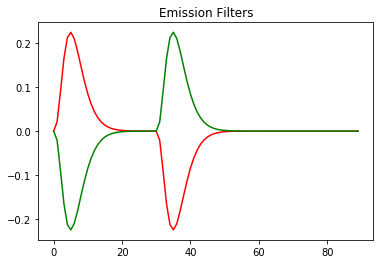

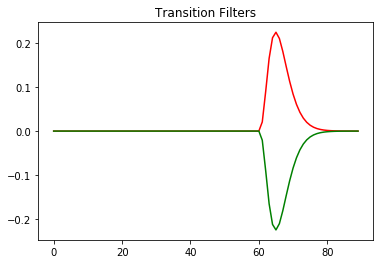

In [10]:
emission1 = np.expand_dims(np.concatenate((filt, -filt, np.zeros(num_filter_bins)), axis = 0), axis = 1)
emission2 = np.expand_dims(np.concatenate((-filt, filt, np.zeros(num_filter_bins)), axis = 0), axis = 1)
emission_filter = np.concatenate((emission1, emission2), axis = 1).T

plt.figure()
plt.title("Emission Filters")
plt.plot(range(0, 90), emission_filter[0, :], "-r")
plt.plot(range(0, 90), emission_filter[1, :], "-g")
plt.show()

transition1 = np.expand_dims(np.concatenate((np.zeros(num_filter_bins), np.zeros(num_filter_bins), filt), axis = 0), axis = 1)
transition2 = np.expand_dims(np.concatenate((np.zeros(num_filter_bins), np.zeros(num_filter_bins), -filt), axis = 0), axis = 1)
transition_filter = np.concatenate((transition1, transition2), axis = 1).T

plt.figure()
plt.title("Transition Filters")
plt.plot(range(0, 90), transition_filter[0, :], "-r")
plt.plot(range(0, 90), transition_filter[1, :], "-g")
plt.show()

## Running the GLM-HMM fitting

Now, we generate an instance of 'GLMHMMEstimator' class with the initial parameters and run the 'fit' method with the simulated variables, 'output_stim' and 'output_symb'. Be cautious that running of the 'fit' method may take few hours:

In [11]:
estimator = GLMHMMEstimator(num_samples = num_samples, num_states = num_states, num_emissions = num_emissions, num_feedbacks = num_feedbacks, num_filter_bins = num_filter_bins, num_steps = num_steps, filter_offset = filter_offset)
output = estimator.fit(output_stim, output_symb, [])

Fitting iteration:   1
Fitting categorical emission filters
Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  2.593e-01  |  3.695e-02  |  4.813e-01  |  2.000e+00  |  1.000e+01  
  2.000e+00  |  2.471e-01  |  2.762e-02  |  1.229e-01  |  1.000e+00  |  1.000e+00  
  3.000e+00  |  2.366e-01  |  9.441e-03  |  2.927e-01  |  1.000e+00  |  1.000e+00  
  4.000e+00  |  2.356e-01  |  3.541e-03  |  6.698e-02  |  1.000e+00  |  1.000e+00  
  5.000e+00  |  2.352e-01  |  2.842e-03  |  3.762e-02  |  1.000e+00  |  1.000e+00  
  6.000e+00  |  2.347e-01  |  4.070e-03  |  1.210e-01  |  1.000e+00  |  1.000e+00  
  7.000e+00  |  2.344e-01  |  6.603e-03  |  1.293e-01  |  1.000e+00  |  1.000e+00  
  8.000e+00  |  2.341e-01  |  3.540e-03  |  3.216e-02  |  1.000e+00  |  1.000e+00  
  9.000e+00  |  2.337e-01  |  2.666e-03  |  1.048e-01  |  1.000e+00

  2.900e+01  |  2.238e-01  |  1.557e-05  |  5.666e-04  |  1.000e+00  |  1.000e+00  
  3.000e+01  |  2.238e-01  |  1.992e-05  |  5.567e-04  |  1.000e+00  |  1.000e+00  
  3.100e+01  |  2.238e-01  |  1.083e-05  |  4.115e-04  |  1.000e+00  |  1.000e+00  
==================================== Summary ======================================
Iterations: 31
Function Evaluations: 34
F: 0.22379343211650848
||g||: 1.0826471225300338e-05
Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  2.706e-01  |  1.563e-02  |  8.875e-02  |  2.000e+00  |  1.000e+01  
  2.000e+00  |  2.675e-01  |  1.492e-02  |  1.479e-01  |  1.000e+00  |  1.000e+00  
  3.000e+00  |  2.670e-01  |  1.277e-02  |  7.081e-02  |  1.000e+00  |  1.000e+00  
  4.000e+00  |  2.664e-01  |  4.776e-03  |  2.433e-02  |  1.000e+00  |  1.000e+00  
  5.000e+00  |  2.662e-01  |  3.92

==================================== Summary ======================================
Iterations: 32
Function Evaluations: 37
F: 0.21756646037101746
||g||: 1.0240613846690394e-05
Fitting state transition filters
Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  1.781e-01  |  9.959e-03  |  4.592e-02  |  2.000e+00  |  1.000e+01  
  2.000e+00  |  1.768e-01  |  4.740e-03  |  4.606e-02  |  1.000e+00  |  1.000e+00  
  3.000e+00  |  1.763e-01  |  3.339e-03  |  3.314e-02  |  1.000e+00  |  1.000e+00  
  4.000e+00  |  1.759e-01  |  1.810e-03  |  4.627e-02  |  1.000e+00  |  1.000e+00  
  5.000e+00  |  1.759e-01  |  2.785e-03  |  3.106e-02  |  1.000e+00  |  1.000e+00  
  6.000e+00  |  1.758e-01  |  7.756e-04  |  9.610e-03  |  1.000e+00  |  1.000e+00  
  7.000e+00  |  1.758e-01  |  6.557e-04  |  4.368e-03  |  1.000e+00  |  1.000e+00  
 

    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  1.424e-01  |  1.490e-02  |  3.320e-02  |  2.000e+00  |  1.000e+01  
  2.000e+00  |  1.386e-01  |  5.430e-03  |  5.290e-02  |  1.000e+00  |  1.000e+00  
  3.000e+00  |  1.378e-01  |  3.688e-03  |  3.012e-02  |  1.000e+00  |  1.000e+00  
  4.000e+00  |  1.373e-01  |  3.625e-03  |  3.997e-02  |  1.000e+00  |  1.000e+00  
  5.000e+00  |  1.370e-01  |  2.952e-03  |  2.880e-02  |  1.000e+00  |  1.000e+00  
  6.000e+00  |  1.369e-01  |  2.064e-03  |  9.511e-03  |  1.000e+00  |  1.000e+00  
  7.000e+00  |  1.365e-01  |  1.741e-03  |  4.270e-02  |  1.000e+00  |  1.000e+00  
  8.000e+00  |  1.364e-01  |  1.297e-03  |  2.901e-02  |  1.000e+00  |  1.000e+00  
  9.000e+00  |  1.362e-01  |  1.140e-03  |  4.058e-02  |  1.000e+00  |  1.000e+00  
  1.000e+01  |  1.362e-01  |  1.569e-03  |  3.647e-02  |  1.000e+00  |  1.00

Log likelihood: 4714.233232261102
Fitting iteration:   6
Fitting categorical emission filters
Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  5.968e-02  |  4.601e-03  |  2.357e-03  |  2.000e+00  |  1.000e+01  
  2.000e+00  |  5.860e-02  |  2.384e-03  |  2.287e-02  |  1.000e+00  |  1.000e+00  
  3.000e+00  |  5.856e-02  |  4.094e-03  |  9.621e-03  |  1.000e+00  |  1.000e+00  
  4.000e+00  |  5.838e-02  |  1.744e-03  |  3.167e-03  |  1.000e+00  |  1.000e+00  
  5.000e+00  |  5.826e-02  |  1.280e-03  |  4.179e-03  |  1.000e+00  |  1.000e+00  
  6.000e+00  |  5.788e-02  |  2.763e-03  |  2.017e-02  |  1.000e+00  |  1.000e+00  
  7.000e+00  |  5.738e-02  |  3.991e-03  |  3.449e-02  |  1.000e+00  |  1.000e+00  
  8.000e+00  |  5.644e-02  |  4.481e-03  |  6.862e-02  |  1.000e+00  |  1.000e+00  
  9.000e+00  |  5.568e-02  |  5.6

  1.800e+01  |  3.505e-02  |  1.397e-03  |  6.373e-02  |  1.000e+00  |  1.000e+00  
  1.900e+01  |  3.483e-02  |  1.463e-03  |  5.237e-02  |  2.000e+00  |  3.846e-01  
  2.000e+01  |  3.459e-02  |  7.219e-04  |  3.959e-02  |  1.000e+00  |  1.000e+00  
  2.100e+01  |  3.445e-02  |  3.942e-04  |  2.889e-02  |  1.000e+00  |  1.000e+00  
  2.200e+01  |  3.438e-02  |  4.645e-04  |  1.286e-02  |  1.000e+00  |  1.000e+00  
  2.300e+01  |  3.431e-02  |  5.777e-04  |  1.550e-02  |  1.000e+00  |  1.000e+00  
  2.400e+01  |  3.425e-02  |  5.226e-04  |  1.296e-02  |  1.000e+00  |  1.000e+00  
  2.500e+01  |  3.419e-02  |  3.423e-04  |  6.071e-03  |  1.000e+00  |  1.000e+00  
  2.600e+01  |  3.414e-02  |  3.569e-04  |  1.043e-02  |  1.000e+00  |  1.000e+00  
  2.700e+01  |  3.412e-02  |  2.972e-04  |  7.877e-03  |  1.000e+00  |  1.000e+00  
  2.800e+01  |  3.409e-02  |  2.071e-04  |  1.325e-02  |  1.000e+00  |  1.000e+00  
  2.900e+01  |  3.408e-02  |  2.192e-04  |  4.869e-03  |  1.000e+00  |  1.00

  3.400e+01  |  2.225e-02  |  6.195e-04  |  4.564e-02  |  1.000e+00  |  1.000e+00  
  3.500e+01  |  2.218e-02  |  3.508e-04  |  1.533e-02  |  1.000e+00  |  1.000e+00  
  3.600e+01  |  2.211e-02  |  3.953e-04  |  1.384e-02  |  1.000e+00  |  1.000e+00  
  3.700e+01  |  2.207e-02  |  4.815e-04  |  8.675e-03  |  1.000e+00  |  1.000e+00  
  3.800e+01  |  2.198e-02  |  4.586e-04  |  2.220e-02  |  1.000e+00  |  1.000e+00  
  3.900e+01  |  2.196e-02  |  8.232e-04  |  3.139e-02  |  1.000e+00  |  1.000e+00  
  4.000e+01  |  2.188e-02  |  1.896e-04  |  8.905e-03  |  1.000e+00  |  1.000e+00  
  4.100e+01  |  2.187e-02  |  1.076e-04  |  1.482e-03  |  1.000e+00  |  1.000e+00  
  4.200e+01  |  2.186e-02  |  1.297e-04  |  2.088e-03  |  1.000e+00  |  1.000e+00  
  4.300e+01  |  2.185e-02  |  1.188e-04  |  2.587e-03  |  1.000e+00  |  1.000e+00  
  4.400e+01  |  2.184e-02  |  1.489e-04  |  2.740e-03  |  2.000e+00  |  4.219e-01  
  4.500e+01  |  2.184e-02  |  6.541e-05  |  3.234e-03  |  1.000e+00  |  1.00

  2.200e+01  |  1.419e-02  |  2.982e-04  |  3.188e-04  |  3.000e+00  |  5.446e+01  
  2.300e+01  |  1.419e-02  |  2.262e-04  |  1.764e-04  |  3.000e+00  |  5.447e+01  
  2.400e+01  |  1.418e-02  |  2.065e-04  |  1.161e-04  |  3.000e+00  |  4.729e+01  
  2.500e+01  |  1.417e-02  |  2.180e-04  |  7.452e-04  |  4.000e+00  |  3.324e+02  
  2.600e+01  |  1.417e-02  |  1.955e-04  |  1.303e-04  |  3.000e+00  |  5.505e+01  
  2.700e+01  |  1.416e-02  |  2.024e-04  |  6.430e-04  |  4.000e+00  |  3.030e+02  
  2.800e+01  |  1.416e-02  |  1.825e-04  |  2.196e-04  |  3.000e+00  |  1.000e+02  
  2.900e+01  |  1.408e-02  |  5.052e-04  |  6.191e-03  |  5.000e+00  |  3.126e+03  
  3.000e+01  |  1.406e-02  |  1.966e-04  |  5.326e-04  |  3.000e+00  |  9.742e+01  
  3.100e+01  |  1.406e-02  |  1.868e-04  |  5.621e-04  |  4.000e+00  |  2.643e+02  
  3.200e+01  |  1.406e-02  |  1.584e-04  |  1.113e-04  |  3.000e+00  |  5.505e+01  
  3.300e+01  |  1.405e-02  |  1.464e-04  |  2.149e-04  |  4.000e+00  |  1.25

  1.000e+01  |  1.502e-02  |  4.081e-04  |  1.137e-03  |  3.000e+00  |  1.000e+02  
  1.100e+01  |  1.463e-02  |  9.059e-04  |  3.132e-02  |  5.000e+00  |  3.030e+03  
  1.200e+01  |  1.460e-02  |  5.985e-04  |  1.239e-03  |  3.000e+00  |  5.505e+01  
  1.300e+01  |  1.458e-02  |  4.478e-04  |  8.182e-04  |  3.000e+00  |  5.505e+01  
  1.400e+01  |  1.457e-02  |  4.003e-04  |  3.934e-04  |  3.000e+00  |  3.539e+01  
  1.500e+01  |  1.456e-02  |  3.338e-04  |  9.934e-04  |  3.000e+00  |  1.000e+02  
  1.600e+01  |  1.452e-02  |  3.404e-04  |  3.405e-03  |  4.000e+00  |  4.113e+02  
  1.700e+01  |  1.450e-02  |  3.158e-04  |  1.591e-03  |  4.000e+00  |  1.889e+02  
  1.800e+01  |  1.435e-02  |  5.242e-04  |  1.302e-02  |  5.000e+00  |  1.668e+03  
  1.900e+01  |  1.434e-02  |  4.043e-04  |  6.265e-04  |  3.000e+00  |  4.884e+01  
  2.000e+01  |  1.433e-02  |  3.369e-04  |  5.445e-04  |  3.000e+00  |  5.505e+01  
  2.100e+01  |  1.430e-02  |  5.291e-04  |  4.215e-03  |  4.000e+00  |  5.11

  2.000e+00  |  7.978e-03  |  1.245e-03  |  9.011e-04  |  3.000e+00  |  1.000e+02  
  3.000e+00  |  7.441e-03  |  9.380e-04  |  3.914e-03  |  4.000e+00  |  5.505e+02  
  4.000e+00  |  7.397e-03  |  7.760e-04  |  2.949e-04  |  3.000e+00  |  5.505e+01  
  5.000e+00  |  7.366e-03  |  6.836e-04  |  2.440e-04  |  3.000e+00  |  5.505e+01  
  6.000e+00  |  7.222e-03  |  7.972e-04  |  2.149e-03  |  4.000e+00  |  5.505e+02  
  7.000e+00  |  7.172e-03  |  4.898e-04  |  4.553e-04  |  3.000e+00  |  1.000e+02  
  8.000e+00  |  7.151e-03  |  4.169e-04  |  2.797e-04  |  3.000e+00  |  1.000e+02  
  9.000e+00  |  7.103e-03  |  3.711e-04  |  7.215e-04  |  4.000e+00  |  3.030e+02  
  1.000e+01  |  7.065e-03  |  3.395e-04  |  6.422e-04  |  4.000e+00  |  3.030e+02  
  1.100e+01  |  7.033e-03  |  3.146e-04  |  5.875e-04  |  4.000e+00  |  3.030e+02  
  1.200e+01  |  6.988e-03  |  3.127e-04  |  9.266e-04  |  4.000e+00  |  5.157e+02  
  1.300e+01  |  6.957e-03  |  4.372e-04  |  9.828e-04  |  4.000e+00  |  5.50

  7.400e+01  |  6.028e-03  |  1.161e-04  |  1.760e-04  |  4.000e+00  |  2.088e+02  
  7.500e+01  |  6.026e-03  |  1.060e-04  |  1.019e-04  |  4.000e+00  |  1.479e+02  
  7.600e+01  |  5.920e-03  |  2.402e-04  |  7.267e-03  |  6.000e+00  |  1.156e+04  
  7.700e+01  |  5.917e-03  |  1.585e-04  |  7.823e-05  |  3.000e+00  |  5.505e+01  
  7.800e+01  |  5.916e-03  |  1.253e-04  |  3.769e-05  |  3.000e+00  |  4.019e+01  
  7.900e+01  |  5.916e-03  |  1.123e-04  |  1.786e-05  |  3.000e+00  |  2.411e+01  
  8.000e+01  |  5.916e-03  |  1.004e-04  |  1.936e-05  |  3.000e+00  |  2.915e+01  
  8.100e+01  |  5.914e-03  |  8.747e-05  |  1.395e-04  |  4.000e+00  |  2.348e+02  
  8.200e+01  |  5.913e-03  |  7.575e-05  |  7.740e-05  |  4.000e+00  |  1.496e+02  
  8.300e+01  |  5.853e-03  |  2.389e-04  |  5.662e-03  |  6.000e+00  |  1.264e+04  
  8.400e+01  |  5.852e-03  |  1.915e-04  |  4.270e-05  |  3.000e+00  |  3.030e+01  
  8.500e+01  |  5.851e-03  |  1.544e-04  |  3.487e-05  |  3.000e+00  |  3.08

  1.020e+02  |  8.276e-03  |  2.874e-04  |  6.542e-03  |  6.000e+00  |  4.562e+03  
  1.030e+02  |  8.273e-03  |  2.578e-04  |  1.661e-04  |  3.000e+00  |  3.527e+01  
  1.040e+02  |  8.270e-03  |  2.209e-04  |  2.167e-04  |  3.000e+00  |  5.131e+01  
  1.050e+02  |  8.268e-03  |  1.893e-04  |  1.991e-04  |  3.000e+00  |  5.505e+01  
  1.060e+02  |  8.266e-03  |  1.645e-04  |  1.706e-04  |  3.000e+00  |  5.505e+01  
  1.070e+02  |  8.261e-03  |  9.097e-05  |  7.783e-04  |  4.000e+00  |  2.888e+02  
  1.080e+02  |  8.253e-03  |  1.182e-04  |  2.076e-03  |  5.000e+00  |  1.394e+03  
  1.090e+02  |  8.252e-03  |  1.020e-04  |  1.932e-04  |  3.000e+00  |  1.000e+02  
  1.100e+02  |  8.250e-03  |  8.893e-05  |  2.779e-04  |  4.000e+00  |  1.668e+02  
  1.110e+02  |  8.248e-03  |  8.098e-05  |  4.250e-04  |  5.000e+00  |  2.926e+02  
  1.120e+02  |  8.217e-03  |  2.273e-04  |  9.110e-03  |  6.000e+00  |  6.890e+03  
  1.130e+02  |  8.203e-03  |  9.594e-05  |  1.548e-03  |  4.000e+00  |  4.20

  5.600e+01  |  6.385e-03  |  9.570e-05  |  1.892e-04  |  4.000e+00  |  1.346e+02  
  5.700e+01  |  6.371e-03  |  1.316e-04  |  2.098e-03  |  5.000e+00  |  1.642e+03  
  5.800e+01  |  6.368e-03  |  1.128e-04  |  5.315e-04  |  4.000e+00  |  3.030e+02  
  5.900e+01  |  6.366e-03  |  9.646e-05  |  3.698e-04  |  4.000e+00  |  2.462e+02  
  6.000e+01  |  6.357e-03  |  1.494e-04  |  1.423e-03  |  5.000e+00  |  1.108e+03  
  6.100e+01  |  6.356e-03  |  1.281e-04  |  8.876e-05  |  3.000e+00  |  4.466e+01  
  6.200e+01  |  6.354e-03  |  9.873e-05  |  4.240e-04  |  4.000e+00  |  2.490e+02  
  6.300e+01  |  6.349e-03  |  1.288e-04  |  8.786e-04  |  4.000e+00  |  6.694e+02  
  6.400e+01  |  6.345e-03  |  1.230e-04  |  5.908e-04  |  4.000e+00  |  3.451e+02  
  6.500e+01  |  6.344e-03  |  9.793e-05  |  1.781e-04  |  4.000e+00  |  1.090e+02  
  6.600e+01  |  6.336e-03  |  2.302e-04  |  1.772e-03  |  5.000e+00  |  1.362e+03  
  6.700e+01  |  6.333e-03  |  1.621e-04  |  2.022e-04  |  3.000e+00  |  6.62

  2.500e+02  |  4.969e-03  |  5.328e-05  |  4.111e-04  |  4.000e+00  |  2.310e+02  
  2.510e+02  |  4.878e-03  |  1.808e-04  |  1.938e-02  |  7.000e+00  |  3.459e+04  
  2.520e+02  |  4.873e-03  |  6.126e-05  |  5.651e-04  |  4.000e+00  |  3.030e+02  
  2.530e+02  |  4.872e-03  |  5.468e-05  |  1.559e-04  |  4.000e+00  |  2.468e+02  
  2.540e+02  |  4.866e-03  |  7.495e-05  |  1.450e-03  |  5.000e+00  |  2.571e+03  
  2.550e+02  |  4.865e-03  |  5.694e-05  |  2.339e-04  |  4.000e+00  |  3.030e+02  
  2.560e+02  |  4.862e-03  |  5.470e-05  |  6.023e-04  |  5.000e+00  |  1.027e+03  
  2.570e+02  |  4.857e-03  |  8.780e-05  |  1.151e-03  |  5.000e+00  |  2.045e+03  
  2.580e+02  |  4.856e-03  |  5.993e-05  |  2.073e-04  |  4.000e+00  |  2.296e+02  
  2.590e+02  |  4.854e-03  |  5.176e-05  |  3.794e-04  |  5.000e+00  |  6.157e+02  
  2.600e+02  |  4.848e-03  |  7.057e-05  |  1.328e-03  |  6.000e+00  |  2.496e+03  
  2.610e+02  |  4.846e-03  |  5.790e-05  |  3.987e-04  |  4.000e+00  |  5.50

  2.300e+01  |  5.163e-03  |  9.307e-05  |  1.726e-04  |  4.000e+00  |  3.030e+02  
  2.400e+01  |  5.160e-03  |  9.799e-05  |  2.181e-04  |  5.000e+00  |  4.170e+02  
  2.500e+01  |  5.159e-03  |  8.361e-05  |  7.887e-05  |  4.000e+00  |  1.432e+02  
  2.600e+01  |  5.149e-03  |  1.092e-04  |  7.291e-04  |  5.000e+00  |  1.552e+03  
  2.700e+01  |  5.148e-03  |  7.885e-05  |  8.908e-05  |  4.000e+00  |  1.452e+02  
  2.800e+01  |  5.139e-03  |  1.375e-04  |  7.387e-04  |  5.000e+00  |  1.668e+03  
  2.900e+01  |  5.137e-03  |  7.879e-05  |  1.021e-04  |  4.000e+00  |  1.322e+02  
  3.000e+01  |  5.136e-03  |  7.342e-05  |  1.121e-04  |  4.000e+00  |  2.533e+02  
  3.100e+01  |  5.130e-03  |  1.089e-04  |  5.574e-04  |  5.000e+00  |  1.352e+03  
  3.200e+01  |  5.129e-03  |  9.823e-05  |  1.852e-05  |  3.000e+00  |  3.030e+01  
  3.300e+01  |  5.128e-03  |  6.985e-05  |  8.279e-05  |  4.000e+00  |  1.501e+02  
  3.400e+01  |  5.113e-03  |  3.210e-04  |  2.090e-03  |  6.000e+00  |  5.33

  1.380e+02  |  4.581e-03  |  2.286e-04  |  2.999e-04  |  3.000e+00  |  1.000e+02  
  1.390e+02  |  4.578e-03  |  1.061e-04  |  1.214e-04  |  3.000e+00  |  1.000e+02  
  1.400e+02  |  4.577e-03  |  9.257e-05  |  1.707e-05  |  3.000e+00  |  3.030e+01  
  1.410e+02  |  4.577e-03  |  6.523e-05  |  4.110e-05  |  4.000e+00  |  8.362e+01  
  1.420e+02  |  4.576e-03  |  4.574e-05  |  5.947e-05  |  4.000e+00  |  1.717e+02  
  1.430e+02  |  4.576e-03  |  3.888e-05  |  5.253e-05  |  4.000e+00  |  2.163e+02  
  1.440e+02  |  4.575e-03  |  3.477e-05  |  9.154e-05  |  5.000e+00  |  4.435e+02  
  1.450e+02  |  4.565e-03  |  9.060e-05  |  1.802e-03  |  7.000e+00  |  9.764e+03  
  1.460e+02  |  4.565e-03  |  8.052e-05  |  1.550e-05  |  3.000e+00  |  3.228e+01  
  1.470e+02  |  4.564e-03  |  5.972e-05  |  1.293e-04  |  4.000e+00  |  3.030e+02  
  1.480e+02  |  4.564e-03  |  5.376e-05  |  9.585e-06  |  3.000e+00  |  3.030e+01  
==================================== Summary ===============================

  1.760e+02  |  3.443e-03  |  2.784e-05  |  1.274e-04  |  5.000e+00  |  3.369e+02  
  1.770e+02  |  3.441e-03  |  3.930e-05  |  7.602e-04  |  5.000e+00  |  3.030e+03  
  1.780e+02  |  3.441e-03  |  3.275e-05  |  5.297e-05  |  4.000e+00  |  1.496e+02  
  1.790e+02  |  3.440e-03  |  3.030e-05  |  2.070e-04  |  5.000e+00  |  7.019e+02  
  1.800e+02  |  3.440e-03  |  2.768e-05  |  1.403e-04  |  5.000e+00  |  5.141e+02  
  1.810e+02  |  3.436e-03  |  7.724e-05  |  1.666e-03  |  7.000e+00  |  6.684e+03  
  1.820e+02  |  3.435e-03  |  5.758e-05  |  7.932e-05  |  4.000e+00  |  1.143e+02  
  1.830e+02  |  3.435e-03  |  3.940e-05  |  8.712e-05  |  4.000e+00  |  1.684e+02  
  1.840e+02  |  3.434e-03  |  2.944e-05  |  8.253e-05  |  4.000e+00  |  2.331e+02  
  1.850e+02  |  3.434e-03  |  2.744e-05  |  7.093e-05  |  5.000e+00  |  2.681e+02  
  1.860e+02  |  3.431e-03  |  4.656e-05  |  1.159e-03  |  6.000e+00  |  4.700e+03  
  1.870e+02  |  3.431e-03  |  3.650e-05  |  5.738e-05  |  4.000e+00  |  1.37

  1.600e+01  |  3.451e-03  |  5.728e-05  |  1.775e-03  |  6.000e+00  |  4.029e+03  
  1.700e+01  |  3.446e-03  |  7.162e-05  |  1.487e-03  |  6.000e+00  |  3.045e+03  
  1.800e+01  |  3.441e-03  |  6.325e-05  |  9.365e-04  |  5.000e+00  |  1.535e+03  
  1.900e+01  |  3.441e-03  |  5.492e-05  |  8.980e-05  |  4.000e+00  |  1.668e+02  
  2.000e+01  |  3.440e-03  |  4.718e-05  |  1.852e-04  |  4.000e+00  |  3.961e+02  
  2.100e+01  |  3.437e-03  |  4.672e-05  |  5.447e-04  |  5.000e+00  |  1.357e+03  
  2.200e+01  |  3.434e-03  |  5.460e-05  |  6.625e-04  |  6.000e+00  |  1.667e+03  
  2.300e+01  |  3.432e-03  |  5.596e-05  |  3.294e-04  |  5.000e+00  |  7.096e+02  
  2.400e+01  |  3.431e-03  |  5.997e-05  |  3.112e-04  |  5.000e+00  |  6.541e+02  
  2.500e+01  |  3.430e-03  |  4.481e-05  |  1.301e-04  |  4.000e+00  |  2.553e+02  
  2.600e+01  |  3.423e-03  |  8.395e-05  |  1.595e-03  |  6.000e+00  |  4.190e+03  
  2.700e+01  |  3.421e-03  |  4.438e-05  |  1.897e-04  |  4.000e+00  |  2.66

  2.100e+02  |  2.679e-03  |  3.478e-05  |  5.464e-04  |  6.000e+00  |  2.709e+03  
  2.110e+02  |  2.678e-03  |  3.008e-05  |  1.973e-04  |  5.000e+00  |  7.961e+02  
  2.120e+02  |  2.678e-03  |  2.966e-05  |  1.796e-04  |  5.000e+00  |  8.382e+02  
  2.130e+02  |  2.677e-03  |  2.766e-05  |  1.350e-04  |  5.000e+00  |  6.387e+02  
  2.140e+02  |  2.677e-03  |  2.853e-05  |  2.083e-04  |  5.000e+00  |  1.057e+03  
  2.150e+02  |  2.676e-03  |  2.817e-05  |  1.556e-04  |  5.000e+00  |  7.659e+02  
  2.160e+02  |  2.675e-03  |  4.815e-05  |  4.693e-04  |  6.000e+00  |  2.340e+03  
  2.170e+02  |  2.674e-03  |  3.539e-05  |  5.708e-05  |  4.000e+00  |  1.666e+02  
  2.180e+02  |  2.674e-03  |  2.800e-05  |  6.698e-05  |  4.000e+00  |  2.660e+02  
  2.190e+02  |  2.672e-03  |  6.309e-05  |  6.863e-04  |  6.000e+00  |  3.445e+03  
  2.200e+02  |  2.671e-03  |  3.738e-05  |  9.865e-05  |  4.000e+00  |  2.199e+02  
  2.210e+02  |  2.671e-03  |  2.700e-05  |  1.113e-04  |  4.000e+00  |  4.18

C:\Users\Aslan\Desktop\Jan\pyGLMHMM_v4\src\pyGLMHMM\transLearningStats.py:43: RuntimeWarning: overflow encountered in multiply
  hess[i, i, :] = np.sum(np.tile(np.reshape(stim[trial]['gamma'][state_num, 0:-1] * (norm * np.exp(filtpower[set_order[i], :]) - np.exp(2 * filtpower[set_order[i], :])) / np.power(norm, 2), (1, 1, T), order = 'F'), (1, num_bins, 1)) * data_vec, axis = 2)
C:\Users\Aslan\Desktop\Jan\pyGLMHMM_v4\src\pyGLMHMM\transLearningStats.py:43: RuntimeWarning: invalid value encountered in subtract
  hess[i, i, :] = np.sum(np.tile(np.reshape(stim[trial]['gamma'][state_num, 0:-1] * (norm * np.exp(filtpower[set_order[i], :]) - np.exp(2 * filtpower[set_order[i], :])) / np.power(norm, 2), (1, 1, T), order = 'F'), (1, num_bins, 1)) * data_vec, axis = 2)
C:\Users\Aslan\Desktop\Jan\pyGLMHMM_v4\src\pyGLMHMM\transLearningStats.py:43: RuntimeWarning: overflow encountered in power
  hess[i, i, :] = np.sum(np.tile(np.reshape(stim[trial]['gamma'][state_num, 0:-1] * (norm * np.exp(filtpowe

Log likelihood: 148.66681090955413
Fitting iteration:   12
Fitting categorical emission filters
Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  4.635e-03  |  2.901e-04  |  9.850e-05  |  3.000e+00  |  5.505e+01  
  2.000e+00  |  4.610e-03  |  2.195e-04  |  8.031e-04  |  4.000e+00  |  4.994e+02  
  3.000e+00  |  4.608e-03  |  1.945e-04  |  5.448e-05  |  3.000e+00  |  4.478e+01  
  4.000e+00  |  4.606e-03  |  1.762e-04  |  5.185e-05  |  3.000e+00  |  4.811e+01  
  5.000e+00  |  4.601e-03  |  1.424e-04  |  1.813e-04  |  4.000e+00  |  1.856e+02  
  6.000e+00  |  4.595e-03  |  1.252e-04  |  2.392e-04  |  4.000e+00  |  3.030e+02  
  7.000e+00  |  4.574e-03  |  9.107e-05  |  1.372e-03  |  5.000e+00  |  1.978e+03  
  8.000e+00  |  4.567e-03  |  1.167e-04  |  5.808e-04  |  5.000e+00  |  1.151e+03  
  9.000e+00  |  4.564e-03  |  9

  7.800e+01  |  1.980e-03  |  3.570e-05  |  5.913e-04  |  5.000e+00  |  2.079e+03  
  7.900e+01  |  1.979e-03  |  2.862e-05  |  9.988e-05  |  5.000e+00  |  3.535e+02  
  8.000e+01  |  1.979e-03  |  2.586e-05  |  2.558e-04  |  5.000e+00  |  1.129e+03  
  8.100e+01  |  1.977e-03  |  4.112e-05  |  6.761e-04  |  6.000e+00  |  3.304e+03  
  8.200e+01  |  1.976e-03  |  2.832e-05  |  9.990e-05  |  5.000e+00  |  3.072e+02  
  8.300e+01  |  1.976e-03  |  2.537e-05  |  1.685e-04  |  5.000e+00  |  7.523e+02  
  8.400e+01  |  1.973e-03  |  9.477e-05  |  1.720e-03  |  7.000e+00  |  8.576e+03  
  8.500e+01  |  1.971e-03  |  2.721e-05  |  3.352e-04  |  4.000e+00  |  4.479e+02  
  8.600e+01  |  1.970e-03  |  2.841e-05  |  2.475e-04  |  5.000e+00  |  1.152e+03  
  8.700e+01  |  1.970e-03  |  2.597e-05  |  4.277e-05  |  5.000e+00  |  1.908e+02  
  8.800e+01  |  1.969e-03  |  2.421e-05  |  1.085e-04  |  5.000e+00  |  5.292e+02  
  8.900e+01  |  1.926e-03  |  4.634e-05  |  1.515e-02  |  8.000e+00  |  7.92

-----------------------------------------------------------------------------------
  1.000e+00  |  4.389e-03  |  8.286e-05  |  6.755e-05  |  4.000e+00  |  1.347e+02  
  2.000e+00  |  4.384e-03  |  7.319e-05  |  4.755e-04  |  5.000e+00  |  1.090e+03  
  3.000e+00  |  4.384e-03  |  6.284e-05  |  4.873e-05  |  4.000e+00  |  1.264e+02  
  4.000e+00  |  4.383e-03  |  5.513e-05  |  6.183e-05  |  4.000e+00  |  1.868e+02  
  5.000e+00  |  4.379e-03  |  1.080e-04  |  7.664e-04  |  5.000e+00  |  2.640e+03  
  6.000e+00  |  4.376e-03  |  6.037e-05  |  1.484e-04  |  4.000e+00  |  2.610e+02  
  7.000e+00  |  4.375e-03  |  4.894e-05  |  2.117e-04  |  5.000e+00  |  6.663e+02  
  8.000e+00  |  4.374e-03  |  4.530e-05  |  4.295e-05  |  4.000e+00  |  1.668e+02  
  9.000e+00  |  4.368e-03  |  1.360e-04  |  1.242e-03  |  6.000e+00  |  5.209e+03  
  1.000e+01  |  4.365e-03  |  5.809e-05  |  1.941e-04  |  4.000e+00  |  2.714e+02  
  1.100e+01  |  4.364e-03  |  4.606e-05  |  5.982e-05  |  4.000e+00  |  1.95

  9.200e+01  |  1.542e-03  |  5.135e-05  |  2.072e-04  |  4.000e+00  |  4.199e+02  
  9.300e+01  |  1.541e-03  |  3.558e-05  |  1.150e-04  |  4.000e+00  |  4.347e+02  
  9.400e+01  |  1.540e-03  |  3.097e-05  |  4.292e-05  |  4.000e+00  |  2.342e+02  
  9.500e+01  |  1.540e-03  |  1.579e-05  |  2.318e-04  |  5.000e+00  |  1.453e+03  
  9.600e+01  |  1.540e-03  |  1.579e-05  |  1.132e-07  |  6.000e+00  |  1.316e+00  
==================================== Summary ======================================
Iterations: 96
Function Evaluations: 480
F: 0.0015395721420645714
||g||: 1.578505543875508e-05
Log likelihood: 113.28203612522131
Fitting iteration:   14
Fitting categorical emission filters
Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  4.165e-03  |  8.961e-05  |  1.857e-04  |  4.000e+00  |  3.030e+02  
  2.000e+00  |  4.16

  3.100e+01  |  1.149e-03  |  3.826e-05  |  5.353e-04  |  7.000e+00  |  4.723e+03  
  3.200e+01  |  1.149e-03  |  3.332e-05  |  2.965e-05  |  4.000e+00  |  1.201e+02  
  3.300e+01  |  1.149e-03  |  2.177e-05  |  8.073e-05  |  5.000e+00  |  3.755e+02  
  3.400e+01  |  1.149e-03  |  1.630e-05  |  9.129e-05  |  6.000e+00  |  6.499e+02  
  3.500e+01  |  1.149e-03  |  1.630e-05  |  1.480e-07  |  6.000e+00  |  1.384e+00  
==================================== Summary ======================================
Iterations: 35
Function Evaluations: 192
F: 0.0011485135182738304
||g||: 1.6303833035635762e-05
Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  1.473e-03  |  1.058e-04  |  1.256e-04  |  4.000e+00  |  1.964e+02  
  2.000e+00  |  1.471e-03  |  9.010e-05  |  1.308e-04  |  4.000e+00  |  2.401e+02  
  3.000e+00  |  1.468e-03  |  7

Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  4.287e-03  |  6.332e-05  |  2.475e-04  |  6.000e+00  |  1.427e+03  
  2.000e+00  |  4.287e-03  |  5.484e-05  |  9.984e-06  |  3.000e+00  |  3.030e+01  
==================================== Summary ======================================
Iterations: 2
Function Evaluations: 10
F: 0.0042870487086474895
||g||: 5.4841351811774075e-05
Fitting state transition filters
Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  1.125e-03  |  1.696e-05  |  2.199e-04  |  6.000e+00  |  1.948e+03  
  2.000e+00  |  1.125e-03  |  1.696e-05  |  1.638e-07  |  6.000e+00  |  1.515e+00  
==================================== Summary ======

-----------------------------------------------------------------------------------
  1.000e+00  |  4.279e-03  |  4.468e-05  |  5.759e-04  |  6.000e+00  |  3.378e+03  
  2.000e+00  |  4.279e-03  |  3.436e-05  |  4.763e-05  |  5.000e+00  |  2.050e+02  
  3.000e+00  |  4.279e-03  |  3.342e-05  |  6.629e-05  |  5.000e+00  |  3.711e+02  
  4.000e+00  |  4.278e-03  |  6.877e-05  |  2.297e-04  |  6.000e+00  |  1.321e+03  
  5.000e+00  |  4.278e-03  |  5.898e-05  |  1.084e-05  |  3.000e+00  |  3.030e+01  
  6.000e+00  |  4.277e-03  |  5.149e-05  |  9.291e-06  |  3.000e+00  |  3.030e+01  
==================================== Summary ======================================
Iterations: 6
Function Evaluations: 29
F: 0.00427745096385479
||g||: 5.149198477738537e-05
Fitting state transition filters
Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1

Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  1.402e-03  |  1.794e-05  |  7.678e-05  |  5.000e+00  |  6.915e+02  
  2.000e+00  |  1.400e-03  |  2.982e-05  |  8.847e-04  |  7.000e+00  |  9.663e+03  
  3.000e+00  |  1.400e-03  |  2.507e-05  |  4.761e-05  |  5.000e+00  |  3.131e+02  
  4.000e+00  |  1.399e-03  |  1.844e-05  |  9.944e-05  |  5.000e+00  |  7.780e+02  
  5.000e+00  |  1.399e-03  |  1.837e-05  |  2.990e-04  |  6.000e+00  |  3.181e+03  
  6.000e+00  |  1.398e-03  |  1.619e-05  |  1.434e-04  |  6.000e+00  |  1.531e+03  
  7.000e+00  |  1.398e-03  |  1.556e-05  |  7.241e-05  |  5.000e+00  |  8.773e+02  
  8.000e+00  |  1.397e-03  |  1.883e-05  |  3.618e-04  |  6.000e+00  |  4.562e+03  
  9.000e+00  |  1.397e-03  |  1.550e-05  |  4.551e-05  |  5.000e+00  |  4.744e+02  
  1.000e+01  |  1.395e-03  |  3.836e-05  | 

  1.000e+01  |  1.113e-03  |  3.539e-05  |  9.176e-04  |  6.000e+00  |  9.179e+03  
  1.100e+01  |  1.112e-03  |  1.888e-05  |  1.155e-04  |  5.000e+00  |  5.111e+02  
  1.200e+01  |  1.112e-03  |  1.545e-05  |  1.174e-04  |  5.000e+00  |  9.744e+02  
  1.300e+01  |  1.109e-03  |  6.889e-05  |  1.908e-03  |  6.000e+00  |  1.933e+04  
  1.400e+01  |  1.108e-03  |  4.305e-05  |  1.352e-04  |  4.000e+00  |  3.079e+02  
  1.500e+01  |  1.108e-03  |  2.777e-05  |  8.911e-05  |  4.000e+00  |  3.248e+02  
  1.600e+01  |  1.107e-03  |  1.750e-05  |  8.401e-05  |  5.000e+00  |  4.748e+02  
  1.700e+01  |  1.107e-03  |  1.509e-05  |  6.884e-05  |  6.000e+00  |  6.173e+02  
  1.800e+01  |  1.107e-03  |  1.509e-05  |  1.196e-07  |  6.000e+00  |  1.250e+00  
==================================== Summary ======================================
Iterations: 18
Function Evaluations: 96
F: 0.0011072265915572643
||g||: 1.5091509339981712e-05
Solving the Minimization Problem
    Iter:    |     F       |    

    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  1.385e-03  |  1.606e-05  |  6.559e-05  |  6.000e+00  |  7.313e+02  
  2.000e+00  |  1.383e-03  |  2.117e-05  |  7.092e-04  |  6.000e+00  |  8.691e+03  
  3.000e+00  |  1.383e-03  |  1.674e-05  |  7.595e-05  |  5.000e+00  |  7.061e+02  
  4.000e+00  |  1.382e-03  |  1.522e-05  |  1.487e-04  |  6.000e+00  |  1.748e+03  
  5.000e+00  |  1.382e-03  |  1.522e-05  |  9.922e-08  |  6.000e+00  |  1.260e+00  
==================================== Summary ======================================
Iterations: 5
Function Evaluations: 30
F: 0.0013822817709296942
||g||: 1.5216797692119144e-05
Log likelihood: 98.75799621979031
Fitting iteration:   26
Fitting categorical emission filters
Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
----------------------

Log likelihood: 97.52109232239074
Fitting iteration:   28
Fitting categorical emission filters
Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  3.511e-03  |  3.630e-05  |  1.524e-05  |  4.000e+00  |  7.003e+01  
  2.000e+00  |  3.510e-03  |  2.712e-05  |  3.131e-05  |  5.000e+00  |  1.768e+02  
  3.000e+00  |  3.509e-03  |  4.169e-05  |  2.206e-04  |  5.000e+00  |  1.668e+03  
  4.000e+00  |  3.509e-03  |  3.576e-05  |  1.287e-05  |  4.000e+00  |  6.330e+01  
  5.000e+00  |  3.509e-03  |  3.041e-05  |  1.709e-05  |  4.000e+00  |  9.796e+01  
  6.000e+00  |  3.509e-03  |  2.764e-05  |  1.833e-05  |  4.000e+00  |  1.236e+02  
  7.000e+00  |  3.509e-03  |  2.672e-05  |  7.371e-05  |  5.000e+00  |  5.468e+02  
  8.000e+00  |  3.508e-03  |  3.660e-05  |  1.339e-04  |  5.000e+00  |  1.028e+03  
  9.000e+00  |  3.508e-03  |  2.

  1.400e+01  |  3.489e-03  |  2.664e-05  |  1.565e-05  |  5.000e+00  |  1.086e+02  
  1.500e+01  |  3.489e-03  |  2.700e-05  |  6.053e-05  |  5.000e+00  |  4.677e+02  
  1.600e+01  |  3.489e-03  |  2.580e-05  |  3.972e-05  |  4.000e+00  |  3.030e+02  
  1.700e+01  |  3.488e-03  |  3.667e-05  |  2.308e-04  |  5.000e+00  |  1.843e+03  
  1.800e+01  |  3.488e-03  |  3.252e-05  |  9.031e-06  |  4.000e+00  |  5.074e+01  
==================================== Summary ======================================
Iterations: 18
Function Evaluations: 78
F: 0.0034875536803156137
||g||: 3.2522752007935196e-05
Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  3.723e-03  |  4.799e-05  |  7.615e-06  |  3.000e+00  |  3.030e+01  
==================================== Summary ======================================
Iterations: 1
Function Evaluatio

  1.000e+00  |  3.364e-03  |  3.923e-05  |  2.089e-04  |  5.000e+00  |  1.769e+03  
  2.000e+00  |  3.363e-03  |  3.256e-05  |  1.255e-05  |  4.000e+00  |  6.751e+01  
  3.000e+00  |  3.363e-03  |  2.926e-05  |  8.813e-06  |  4.000e+00  |  5.715e+01  
==================================== Summary ======================================
Iterations: 3
Function Evaluations: 14
F: 0.003363386495038867
||g||: 2.925983426393941e-05
Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  3.689e-03  |  4.232e-05  |  1.282e-05  |  3.000e+00  |  5.162e+01  
  2.000e+00  |  3.689e-03  |  2.702e-05  |  3.272e-05  |  4.000e+00  |  1.645e+02  
  3.000e+00  |  3.686e-03  |  9.020e-05  |  6.112e-04  |  6.000e+00  |  4.814e+03  
  4.000e+00  |  3.686e-03  |  7.417e-05  |  1.601e-05  |  3.000e+00  |  3.781e+01  
  5.000e+00  |  3.686e-03  |  5.250

  4.500e+01  |  3.107e-03  |  4.258e-05  |  8.199e-04  |  6.000e+00  |  7.810e+03  
  4.600e+01  |  3.106e-03  |  3.190e-05  |  1.715e-05  |  4.000e+00  |  8.943e+01  
  4.700e+01  |  3.106e-03  |  2.614e-05  |  5.475e-05  |  5.000e+00  |  3.812e+02  
  4.800e+01  |  3.106e-03  |  2.700e-05  |  5.990e-05  |  5.000e+00  |  5.090e+02  
  4.900e+01  |  3.106e-03  |  2.226e-05  |  3.317e-05  |  5.000e+00  |  2.728e+02  
  5.000e+01  |  3.106e-03  |  2.226e-05  |  1.299e-07  |  6.000e+00  |  1.311e+00  
==================================== Summary ======================================
Iterations: 50
Function Evaluations: 241
F: 0.003105764975771308
||g||: 2.226211472589057e-05
Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  3.618e-03  |  3.584e-05  |  1.326e-05  |  4.000e+00  |  6.453e+01  
  2.000e+00  |  3.618e-03  |  3.0

-----------------------------------------------------------------------------------
  1.000e+00  |  1.049e-03  |  1.390e-05  |  1.319e-07  |  9.000e+00  |  1.531e+00  
==================================== Summary ======================================
Iterations: 1
Function Evaluations: 10
F: 0.001048776670359075
||g||: 1.3900855265092105e-05
Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  1.340e-03  |  1.478e-05  |  5.068e-05  |  6.000e+00  |  6.096e+02  
  2.000e+00  |  1.338e-03  |  1.905e-05  |  6.074e-04  |  7.000e+00  |  8.161e+03  
  3.000e+00  |  1.338e-03  |  1.803e-05  |  1.404e-04  |  6.000e+00  |  1.464e+03  
  4.000e+00  |  1.338e-03  |  1.546e-05  |  2.867e-05  |  5.000e+00  |  3.160e+02  
  5.000e+00  |  1.338e-03  |  1.395e-05  |  6.123e-05  |  5.000e+00  |  7.868e+02  
  6.000e+00  |  1.338e-03  |  1.39

    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  3.587e-03  |  2.517e-05  |  1.817e-05  |  5.000e+00  |  1.360e+02  
  2.000e+00  |  3.587e-03  |  3.060e-05  |  1.196e-04  |  6.000e+00  |  1.029e+03  
  3.000e+00  |  3.587e-03  |  2.527e-05  |  1.890e-05  |  4.000e+00  |  1.338e+02  
  4.000e+00  |  3.586e-03  |  5.340e-05  |  2.227e-04  |  6.000e+00  |  1.910e+03  
  5.000e+00  |  3.585e-03  |  4.678e-05  |  7.467e-06  |  3.000e+00  |  3.030e+01  
==================================== Summary ======================================
Iterations: 5
Function Evaluations: 25
F: 0.0035854734014719725
||g||: 4.6783647121628746e-05
Fitting state transition filters
Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------


  5.000e+00  |  3.540e-03  |  1.397e-04  |  4.387e-05  |  3.000e+00  |  5.344e+01  
  6.000e+00  |  3.539e-03  |  1.199e-04  |  2.376e-05  |  3.000e+00  |  3.721e+01  
  7.000e+00  |  3.539e-03  |  9.688e-05  |  3.017e-05  |  3.000e+00  |  5.505e+01  
  8.000e+00  |  3.538e-03  |  8.266e-05  |  2.123e-05  |  3.000e+00  |  4.793e+01  
  9.000e+00  |  3.538e-03  |  6.200e-05  |  3.644e-05  |  4.000e+00  |  9.641e+01  
  1.000e+01  |  3.537e-03  |  3.533e-05  |  9.283e-05  |  4.000e+00  |  3.275e+02  
  1.100e+01  |  3.537e-03  |  2.695e-05  |  3.874e-05  |  4.000e+00  |  2.398e+02  
  1.200e+01  |  3.536e-03  |  3.824e-05  |  1.584e-04  |  5.000e+00  |  1.286e+03  
  1.300e+01  |  3.536e-03  |  2.653e-05  |  2.914e-05  |  4.000e+00  |  1.668e+02  
  1.400e+01  |  3.535e-03  |  2.647e-05  |  9.465e-05  |  5.000e+00  |  7.806e+02  
  1.500e+01  |  3.535e-03  |  2.454e-05  |  1.836e-05  |  4.000e+00  |  1.518e+02  
  1.600e+01  |  3.534e-03  |  2.953e-05  |  1.899e-04  |  6.000e+00  |  1.69

    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  2.998e-03  |  2.114e-05  |  5.569e-05  |  5.000e+00  |  5.647e+02  
  2.000e+00  |  2.992e-03  |  6.675e-05  |  1.272e-03  |  7.000e+00  |  1.368e+04  
  3.000e+00  |  2.992e-03  |  3.653e-05  |  4.890e-05  |  4.000e+00  |  1.668e+02  
  4.000e+00  |  2.992e-03  |  3.048e-05  |  1.822e-05  |  4.000e+00  |  1.136e+02  
  5.000e+00  |  2.991e-03  |  2.745e-05  |  1.402e-05  |  4.000e+00  |  1.048e+02  
  6.000e+00  |  2.991e-03  |  2.320e-05  |  7.860e-05  |  6.000e+00  |  6.518e+02  
  7.000e+00  |  2.991e-03  |  2.318e-05  |  1.269e-07  |  6.000e+00  |  1.399e+00  
==================================== Summary ======================================
Iterations: 7
Function Evaluations: 37
F: 0.002991110784932971
||g||: 2.318134283996187e-05
Solving the Minimization Problem
    Iter:    |     F       |    ||g

F: 0.002989581087604165
||g||: 2.6005829568021e-05
Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  3.509e-03  |  2.515e-05  |  1.069e-05  |  4.000e+00  |  8.510e+01  
  2.000e+00  |  3.508e-03  |  5.734e-05  |  1.725e-04  |  6.000e+00  |  1.508e+03  
  3.000e+00  |  3.508e-03  |  4.165e-05  |  1.718e-05  |  4.000e+00  |  6.588e+01  
  4.000e+00  |  3.508e-03  |  3.735e-05  |  5.732e-06  |  3.000e+00  |  3.030e+01  
==================================== Summary ======================================
Iterations: 4
Function Evaluations: 18
F: 0.003507734276354313
||g||: 3.735294740181416e-05
Fitting state transition filters
Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  

  7.000e+00  |  3.500e-03  |  6.207e-05  |  9.926e-06  |  3.000e+00  |  3.030e+01  
==================================== Summary ======================================
Iterations: 7
Function Evaluations: 28
F: 0.003500123042613268
||g||: 6.207012484082952e-05
Fitting state transition filters
Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  1.041e-03  |  1.392e-05  |  1.333e-07  |  6.000e+00  |  1.539e+00  
==================================== Summary ======================================
Iterations: 1
Function Evaluations: 7
F: 0.0010413966374471784
||g||: 1.3923900951340329e-05
Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  1.289e-03  |  1.832e-05  |  

-----------------------------------------------------------------------------------
  1.000e+00  |  1.287e-03  |  1.408e-05  |  9.300e-08  |  6.000e+00  |  1.185e+00  
==================================== Summary ======================================
Iterations: 1
Function Evaluations: 7
F: 0.0012874227249994874
||g||: 1.4080238543101586e-05
Log likelihood: 88.02539485758388
Fitting iteration:   64
Fitting categorical emission filters
Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  2.827e-03  |  1.200e-04  |  3.492e-02  |  9.000e+00  |  3.804e+05  
  2.000e+00  |  2.827e-03  |  1.048e-04  |  1.774e-05  |  3.000e+00  |  3.491e+01  
  3.000e+00  |  2.826e-03  |  5.240e-05  |  6.458e-05  |  4.000e+00  |  1.455e+02  
  4.000e+00  |  2.826e-03  |  3.805e-05  |  2.348e-05  |  4.000e+00  |  1.058e+02  
  5.000e+00  |  2.825e-

  3.000e+00  |  2.815e-03  |  4.159e-05  |  2.383e-05  |  4.000e+00  |  9.324e+01  
  4.000e+00  |  2.815e-03  |  2.373e-05  |  2.934e-05  |  4.000e+00  |  1.668e+02  
  5.000e+00  |  2.815e-03  |  2.129e-05  |  1.047e-05  |  4.000e+00  |  1.045e+02  
  6.000e+00  |  2.815e-03  |  1.983e-05  |  1.956e-05  |  5.000e+00  |  2.172e+02  
  7.000e+00  |  2.815e-03  |  1.983e-05  |  1.240e-07  |  7.000e+00  |  1.576e+00  
==================================== Summary ======================================
Iterations: 7
Function Evaluations: 35
F: 0.0028149967547506094
||g||: 1.9833179976558313e-05
Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  3.484e-03  |  2.392e-05  |  2.051e-05  |  5.000e+00  |  1.603e+02  
  2.000e+00  |  3.483e-03  |  3.719e-05  |  2.610e-04  |  5.000e+00  |  2.409e+03  
  3.000e+00  |  3.483e-03  |  3.0

  3.000e+00  |  3.406e-03  |  1.365e-04  |  4.327e-05  |  3.000e+00  |  5.401e+01  
  4.000e+00  |  3.405e-03  |  1.197e-04  |  1.796e-05  |  3.000e+00  |  2.951e+01  
  5.000e+00  |  3.405e-03  |  1.078e-04  |  1.324e-05  |  3.000e+00  |  2.482e+01  
  6.000e+00  |  3.404e-03  |  8.037e-05  |  3.286e-05  |  3.000e+00  |  6.836e+01  
  7.000e+00  |  3.403e-03  |  4.248e-05  |  7.168e-05  |  4.000e+00  |  2.000e+02  
  8.000e+00  |  3.403e-03  |  3.157e-05  |  5.322e-05  |  4.000e+00  |  2.809e+02  
  9.000e+00  |  3.402e-03  |  2.708e-05  |  3.787e-05  |  5.000e+00  |  2.690e+02  
  1.000e+01  |  3.402e-03  |  2.373e-05  |  1.112e-04  |  6.000e+00  |  9.207e+02  
  1.100e+01  |  3.402e-03  |  2.373e-05  |  1.419e-07  |  7.000e+00  |  1.471e+00  
==================================== Summary ======================================
Iterations: 11
Function Evaluations: 50
F: 0.0034018668811768293
||g||: 2.3729371605440974e-05
Fitting state transition filters
Solving the Minimization Problem

Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  1.262e-03  |  1.380e-05  |  9.909e-08  |  6.000e+00  |  1.498e+00  
==================================== Summary ======================================
Iterations: 1
Function Evaluations: 7
F: 0.001261855592019856
||g||: 1.3796588973491453e-05
Log likelihood: 84.70639392764323
Fitting iteration:   77
Fitting categorical emission filters
Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  2.772e-03  |  1.961e-05  |  1.221e-07  |  6.000e+00  |  1.521e+00  
==================================== Summary ======================================
Iterations: 1
Function Evaluations: 7
F: 0.0027722488157451153
||g||: 1.961

## The initial emission and transtion matrices

Because the total probability is one, we can arbitrarily set one set of filters for one emitted bahavior or state to zero. So in our example, we would have an emission matrix with the size of ((num_states) * (num_emissions - 1) * (num_feedbacks * num_filter_bins + 1)) = (2, 1, 91) and a transition matrix with the size of (num_states * num_states * (num_feedbacks * num_filter_bins + 1)) = (2, 2, 91) in which the diagonal elements would be ignored. Here are the plots for initial emission and transition matrices which must be compared with the filters plots:

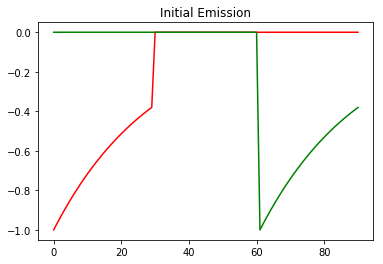

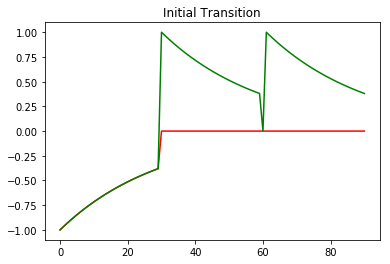

In [12]:
plt.figure()
plt.title("Initial Emission")
plt.plot(range(0, 91), estimator.emit_w_init_[0, 0, :], "-r")
plt.plot(range(0, 91), estimator.emit_w_init_[1, 0, :], "-g")
plt.show()

plt.figure()
plt.title("Initial Transition")
plt.plot(range(0, 91), estimator.trans_w_init_[0, 1, :], "-r")
plt.plot(range(0, 91), estimator.trans_w_init_[1, 0, :], "-g")
plt.show()

## The final emission and transtion matrices

The output is a dictionary which has many useful varaiables generated through consecutive iterations of the EM algorithm of the 'fit' method. Here, we plot the final emission and transition matrices which must be compared with the initial ones and also with filters plots:

In [13]:
emit_w_final = output[-1]['emit_w']
trans_w_final = output[-1]['trans_w']

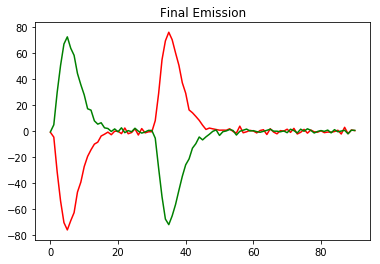

In [14]:
plt.figure()
plt.title("Final Emission")
plt.plot(range(0, 91), emit_w_final[0, 0, :], "-r")
plt.plot(range(0, 91), emit_w_final[1, 0, :], "-g")
plt.show()

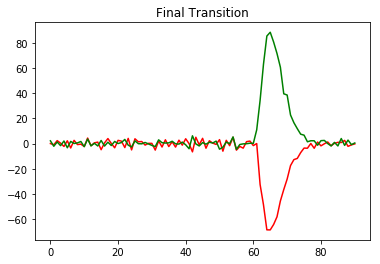

In [15]:
plt.figure()
plt.title("Final Transition")
plt.plot(range(0, 91), trans_w_final[0, 1, :], "-r")
plt.plot(range(0, 91), trans_w_final[1, 0, :], "-g")
plt.show()

## Another similar example with num_sample = 5

In [16]:
num_samples = 5
num_states = 2
num_emissions = 2
num_feedbacks = 3
num_filter_bins = 30
num_steps = 1
filter_offset = 1
    
tau = 4
total_time = 10000
noiseSD = 0.1
stim_scale = 1
num_real_states = 2
    
stim = []
states = []
output_stim = []
output_symb = []
    
for ns in range(0, num_samples):
    output = np.zeros((num_real_states, total_time))
    
    stim_temp = np.zeros((num_filter_bins, total_time + num_filter_bins - 1, num_feedbacks))
    stim_temp[0, :, :] = scipy.ndimage.filters.gaussian_filter(np.random.randn(total_time + num_filter_bins - 1, num_feedbacks), stim_scale)
    
    for i in range(1, num_filter_bins):
        stim_temp[i, 0:total_time, :] = stim_temp[0, i:(total_time + i), :]
        
    stim.append(stim_temp[:, 0:total_time, :] + np.random.randn(num_filter_bins, total_time, num_feedbacks) * noiseSD)
        
    final_stim = np.append(stim[ns][:, :, 0], stim[ns][:, :, 1], axis = 0)
    final_stim = np.append(final_stim, stim[ns][:, :, 2], axis = 0)
    final_stim = np.append(final_stim, np.ones((filter_offset, total_time)), axis = 0)
    output_stim.append(final_stim)
        
    filt = scipy.stats.gamma.pdf(np.linspace(0, num_filter_bins), a = tau)[0:num_filter_bins]
    
    p1 = np.exp(np.matmul(stim[ns][:, :, 0].T, filt.T) + np.matmul(stim[ns][:, :, 1].T, -filt.T))
    output[0, :] = p1 / (1 + p1) > 0.5
    p2 = np.exp(np.matmul(stim[ns][:, :, 0].T, -filt.T) + np.matmul(stim[ns][:, :, 1].T, filt.T))
    output[1, :] = p2 / (1 + p2) > 0.5
    
    p3 = np.exp(np.matmul(stim[ns][:, :, 2].T, filt.T))
    states.append(p3 / (1 + p3) > 0.5)
    
    output_symb.append(np.zeros(total_time))
    for ss in range(0, num_real_states):
        output_symb[ns][states[ns] == ss] = output[ss][states[ns] == ss]
    
estimator = GLMHMMEstimator(num_samples = num_samples, num_states = num_states, num_emissions = num_emissions, num_feedbacks = num_feedbacks, num_filter_bins = num_filter_bins, num_steps = num_steps, filter_offset = filter_offset)
output = estimator.fit(output_stim, output_symb, [])

Fitting iteration:   1
Fitting categorical emission filters
Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  3.303e-01  |  5.074e-02  |  2.303e-01  |  2.000e+00  |  1.000e+01  
  2.000e+00  |  2.930e-01  |  3.765e-02  |  4.477e-01  |  1.000e+00  |  1.000e+00  
  3.000e+00  |  2.855e-01  |  1.299e-02  |  1.537e-01  |  1.000e+00  |  1.000e+00  
  4.000e+00  |  2.841e-01  |  1.192e-02  |  5.504e-02  |  1.000e+00  |  1.000e+00  
  5.000e+00  |  2.798e-01  |  1.321e-02  |  4.382e-01  |  1.000e+00  |  1.000e+00  
  6.000e+00  |  2.791e-01  |  1.957e-02  |  2.732e-01  |  1.000e+00  |  1.000e+00  
  7.000e+00  |  2.773e-01  |  6.726e-03  |  1.313e-01  |  1.000e+00  |  1.000e+00  
  8.000e+00  |  2.764e-01  |  4.453e-03  |  1.138e-01  |  1.000e+00  |  1.000e+00  
  9.000e+00  |  2.740e-01  |  6.288e-03  |  5.443e-01  |  1.000e+00

-----------------------------------------------------------------------------------
  1.000e+00  |  2.752e-01  |  1.133e-02  |  8.919e-02  |  2.000e+00  |  1.000e+01  
  2.000e+00  |  2.736e-01  |  6.862e-03  |  1.104e-01  |  1.000e+00  |  1.000e+00  
  3.000e+00  |  2.734e-01  |  9.152e-03  |  5.926e-02  |  1.000e+00  |  1.000e+00  
  4.000e+00  |  2.731e-01  |  4.102e-03  |  1.602e-02  |  1.000e+00  |  1.000e+00  
  5.000e+00  |  2.729e-01  |  3.213e-03  |  2.384e-02  |  1.000e+00  |  1.000e+00  
  6.000e+00  |  2.726e-01  |  5.247e-03  |  6.371e-02  |  1.000e+00  |  1.000e+00  
  7.000e+00  |  2.721e-01  |  6.450e-03  |  9.841e-02  |  1.000e+00  |  1.000e+00  
  8.000e+00  |  2.713e-01  |  7.697e-03  |  2.155e-01  |  1.000e+00  |  1.000e+00  
  9.000e+00  |  2.711e-01  |  6.091e-03  |  5.778e-02  |  2.000e+00  |  3.085e-01  
  1.000e+01  |  2.709e-01  |  1.953e-03  |  3.926e-02  |  1.000e+00  |  1.000e+00  
  1.100e+01  |  2.709e-01  |  4.649e-04  |  7.691e-03  |  1.000e+00  |  1.00

  1.800e+01  |  1.711e-01  |  7.992e-05  |  2.786e-03  |  1.000e+00  |  1.000e+00  
  1.900e+01  |  1.711e-01  |  9.615e-05  |  4.450e-03  |  1.000e+00  |  1.000e+00  
  2.000e+01  |  1.711e-01  |  1.026e-04  |  4.802e-03  |  1.000e+00  |  1.000e+00  
  2.100e+01  |  1.711e-01  |  3.517e-05  |  8.070e-04  |  1.000e+00  |  1.000e+00  
  2.200e+01  |  1.711e-01  |  2.800e-05  |  8.190e-04  |  1.000e+00  |  1.000e+00  
  2.300e+01  |  1.711e-01  |  2.559e-05  |  7.957e-04  |  1.000e+00  |  1.000e+00  
  2.400e+01  |  1.711e-01  |  1.751e-05  |  1.559e-03  |  1.000e+00  |  1.000e+00  
  2.500e+01  |  1.711e-01  |  1.751e-05  |  0.000e+00  |  1.200e+01  |  0.000e+00  
==================================== Summary ======================================
Iterations: 25
Function Evaluations: 40
F: 0.17114625871181488
||g||: 1.7507574739283882e-05
Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
----------------------------------

==================================== Summary ======================================
Iterations: 27
Function Evaluations: 30
F: 0.14278936386108398
||g||: 1.2510902706708293e-05
Log likelihood: 32417.34121954486
Fitting iteration:   5
Fitting categorical emission filters
Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  7.807e-02  |  6.066e-03  |  5.647e-03  |  2.000e+00  |  1.000e+01  
  2.000e+00  |  7.669e-02  |  5.763e-03  |  2.269e-02  |  1.000e+00  |  1.000e+00  
  3.000e+00  |  7.536e-02  |  6.561e-03  |  2.985e-02  |  1.000e+00  |  1.000e+00  
  4.000e+00  |  7.289e-02  |  6.684e-03  |  7.449e-02  |  1.000e+00  |  1.000e+00  
  5.000e+00  |  7.198e-02  |  4.981e-03  |  4.331e-02  |  2.000e+00  |  3.941e-01  
  6.000e+00  |  7.124e-02  |  2.635e-03  |  3.338e-02  |  1.000e+00  |  1.000e+00  
  7.000e+00  |  7.072e-0

-----------------------------------------------------------------------------------
  1.000e+00  |  1.901e-01  |  3.859e-03  |  6.151e-03  |  2.000e+00  |  1.000e+01  
  2.000e+00  |  1.899e-01  |  3.088e-03  |  9.191e-03  |  1.000e+00  |  1.000e+00  
  3.000e+00  |  1.897e-01  |  1.075e-03  |  1.171e-02  |  1.000e+00  |  1.000e+00  
  4.000e+00  |  1.897e-01  |  8.428e-04  |  4.472e-03  |  1.000e+00  |  1.000e+00  
  5.000e+00  |  1.896e-01  |  8.965e-04  |  9.086e-03  |  1.000e+00  |  1.000e+00  
  6.000e+00  |  1.896e-01  |  1.345e-03  |  1.169e-02  |  1.000e+00  |  1.000e+00  
  7.000e+00  |  1.895e-01  |  1.280e-03  |  2.458e-02  |  1.000e+00  |  1.000e+00  
  8.000e+00  |  1.895e-01  |  1.704e-03  |  1.583e-02  |  2.000e+00  |  3.311e-01  
  9.000e+00  |  1.894e-01  |  6.011e-04  |  2.150e-02  |  1.000e+00  |  1.000e+00  
  1.000e+01  |  1.894e-01  |  2.723e-04  |  3.117e-03  |  1.000e+00  |  1.000e+00  
  1.100e+01  |  1.894e-01  |  1.558e-04  |  1.582e-03  |  1.000e+00  |  1.00

  9.000e+00  |  1.636e-01  |  4.343e-04  |  1.207e-02  |  1.000e+00  |  1.000e+00  
  1.000e+01  |  1.636e-01  |  4.509e-04  |  2.045e-02  |  1.000e+00  |  1.000e+00  
  1.100e+01  |  1.636e-01  |  2.949e-04  |  1.537e-02  |  1.000e+00  |  1.000e+00  
  1.200e+01  |  1.636e-01  |  2.032e-04  |  8.671e-03  |  1.000e+00  |  1.000e+00  
  1.300e+01  |  1.636e-01  |  1.266e-04  |  2.502e-03  |  1.000e+00  |  1.000e+00  
  1.400e+01  |  1.636e-01  |  1.137e-04  |  1.495e-03  |  1.000e+00  |  1.000e+00  
  1.500e+01  |  1.636e-01  |  1.531e-04  |  8.500e-03  |  1.000e+00  |  1.000e+00  
  1.600e+01  |  1.636e-01  |  7.728e-05  |  3.361e-03  |  2.000e+00  |  4.140e-01  
  1.700e+01  |  1.636e-01  |  5.654e-05  |  2.030e-03  |  1.000e+00  |  1.000e+00  
  1.800e+01  |  1.636e-01  |  7.062e-05  |  3.873e-03  |  1.000e+00  |  1.000e+00  
  1.900e+01  |  1.636e-01  |  8.767e-05  |  3.261e-03  |  1.000e+00  |  1.000e+00  
  2.000e+01  |  1.636e-01  |  5.150e-05  |  1.323e-03  |  1.000e+00  |  1.00

  2.800e+01  |  1.582e-01  |  2.789e-05  |  4.269e-04  |  1.000e+00  |  1.000e+00  
  2.900e+01  |  1.582e-01  |  6.552e-06  |  1.043e-04  |  1.000e+00  |  1.000e+00  
==================================== Summary ======================================
Iterations: 29
Function Evaluations: 31
F: 0.15823744237422943
||g||: 6.551680598931853e-06
Fitting state transition filters
Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  1.502e-01  |  1.302e-02  |  6.344e-02  |  2.000e+00  |  1.000e+01  
  2.000e+00  |  1.477e-01  |  5.734e-03  |  7.158e-02  |  1.000e+00  |  1.000e+00  
  3.000e+00  |  1.469e-01  |  3.625e-03  |  5.003e-02  |  1.000e+00  |  1.000e+00  
  4.000e+00  |  1.462e-01  |  2.850e-03  |  6.333e-02  |  1.000e+00  |  1.000e+00  
  5.000e+00  |  1.459e-01  |  2.864e-03  |  8.997e-02  |  1.000e+00  |  1.000e+00  
  

  2.000e+00  |  1.179e-01  |  6.295e-03  |  7.305e-02  |  1.000e+00  |  1.000e+00  
  3.000e+00  |  1.168e-01  |  4.509e-03  |  5.171e-02  |  1.000e+00  |  1.000e+00  
  4.000e+00  |  1.155e-01  |  3.846e-03  |  8.328e-02  |  1.000e+00  |  1.000e+00  
  5.000e+00  |  1.143e-01  |  3.370e-03  |  1.400e-01  |  1.000e+00  |  1.000e+00  
  6.000e+00  |  1.140e-01  |  2.144e-03  |  4.341e-02  |  2.000e+00  |  3.117e-01  
  7.000e+00  |  1.139e-01  |  7.222e-04  |  2.843e-02  |  1.000e+00  |  1.000e+00  
  8.000e+00  |  1.139e-01  |  3.748e-04  |  8.487e-03  |  1.000e+00  |  1.000e+00  
  9.000e+00  |  1.139e-01  |  4.221e-04  |  7.024e-03  |  1.000e+00  |  1.000e+00  
  1.000e+01  |  1.138e-01  |  5.907e-04  |  1.614e-02  |  1.000e+00  |  1.000e+00  
  1.100e+01  |  1.138e-01  |  7.906e-04  |  2.875e-02  |  1.000e+00  |  1.000e+00  
  1.200e+01  |  1.138e-01  |  3.920e-04  |  1.957e-02  |  1.000e+00  |  1.000e+00  
  1.300e+01  |  1.138e-01  |  1.891e-04  |  7.899e-03  |  1.000e+00  |  1.00

  1.210e+02  |  9.073e-03  |  8.869e-05  |  2.442e-05  |  3.000e+00  |  3.030e+01  
  1.220e+02  |  9.072e-03  |  4.479e-05  |  1.044e-04  |  4.000e+00  |  1.564e+02  
  1.230e+02  |  9.072e-03  |  4.773e-05  |  1.381e-04  |  5.000e+00  |  4.097e+02  
  1.240e+02  |  9.071e-03  |  4.775e-05  |  1.009e-04  |  4.000e+00  |  2.809e+02  
  1.250e+02  |  9.071e-03  |  4.546e-05  |  8.770e-05  |  5.000e+00  |  2.441e+02  
  1.260e+02  |  9.070e-03  |  4.105e-05  |  5.435e-05  |  4.000e+00  |  1.589e+02  
  1.270e+02  |  9.063e-03  |  1.356e-04  |  1.576e-03  |  6.000e+00  |  5.102e+03  
  1.280e+02  |  9.063e-03  |  1.171e-04  |  2.069e-05  |  3.000e+00  |  2.030e+01  
  1.290e+02  |  9.062e-03  |  7.869e-05  |  4.566e-05  |  3.000e+00  |  5.188e+01  
  1.300e+02  |  9.062e-03  |  5.173e-05  |  4.116e-05  |  4.000e+00  |  6.962e+01  
  1.310e+02  |  9.062e-03  |  4.087e-05  |  3.888e-05  |  5.000e+00  |  1.000e+02  
  1.320e+02  |  9.061e-03  |  4.745e-05  |  1.665e-04  |  6.000e+00  |  5.42

  6.800e+01  |  1.237e-02  |  1.549e-04  |  1.763e-04  |  3.000e+00  |  5.100e+01  
  6.900e+01  |  1.236e-02  |  1.571e-04  |  8.154e-04  |  4.000e+00  |  2.636e+02  
  7.000e+01  |  1.236e-02  |  1.439e-04  |  4.350e-04  |  4.000e+00  |  1.389e+02  
  7.100e+01  |  1.223e-02  |  4.187e-04  |  2.102e-02  |  6.000e+00  |  7.324e+03  
  7.200e+01  |  1.221e-02  |  1.753e-04  |  7.494e-04  |  3.000e+00  |  9.162e+01  
  7.300e+01  |  1.221e-02  |  1.370e-04  |  3.424e-04  |  3.000e+00  |  1.000e+02  
  7.400e+01  |  1.219e-02  |  2.867e-04  |  3.933e-03  |  5.000e+00  |  1.471e+03  
  7.500e+01  |  1.219e-02  |  1.966e-04  |  3.070e-04  |  3.000e+00  |  5.505e+01  
  7.600e+01  |  1.218e-02  |  1.696e-04  |  1.341e-04  |  3.000e+00  |  3.508e+01  
  7.700e+01  |  1.218e-02  |  1.539e-04  |  1.124e-04  |  3.000e+00  |  3.406e+01  
  7.800e+01  |  1.218e-02  |  1.514e-04  |  7.440e-04  |  4.000e+00  |  2.487e+02  
  7.900e+01  |  1.218e-02  |  1.332e-04  |  3.313e-04  |  4.000e+00  |  1.12

  3.200e+01  |  8.364e-03  |  8.988e-05  |  1.984e-04  |  4.000e+00  |  3.422e+02  
  3.300e+01  |  8.364e-03  |  7.755e-05  |  3.041e-05  |  4.000e+00  |  4.532e+01  
  3.400e+01  |  8.363e-03  |  6.703e-05  |  6.325e-05  |  4.000e+00  |  1.092e+02  
  3.500e+01  |  8.345e-03  |  3.110e-04  |  3.213e-03  |  6.000e+00  |  6.420e+03  
  3.600e+01  |  8.342e-03  |  2.343e-04  |  7.770e-05  |  3.000e+00  |  3.354e+01  
  3.700e+01  |  8.340e-03  |  1.734e-04  |  6.374e-05  |  3.000e+00  |  3.652e+01  
  3.800e+01  |  8.339e-03  |  1.430e-04  |  3.359e-05  |  3.000e+00  |  2.601e+01  
  3.900e+01  |  8.339e-03  |  1.135e-04  |  3.488e-05  |  3.000e+00  |  3.275e+01  
  4.000e+01  |  8.338e-03  |  9.992e-05  |  1.804e-05  |  3.000e+00  |  2.133e+01  
  4.100e+01  |  8.338e-03  |  7.964e-05  |  3.104e-05  |  4.000e+00  |  4.172e+01  
  4.200e+01  |  8.338e-03  |  6.618e-05  |  2.991e-05  |  4.000e+00  |  5.043e+01  
  4.300e+01  |  8.337e-03  |  5.640e-05  |  6.238e-05  |  4.000e+00  |  1.26

  5.100e+01  |  6.741e-03  |  3.474e-04  |  3.313e-04  |  3.000e+00  |  5.505e+01  
  5.200e+01  |  6.735e-03  |  2.618e-04  |  2.459e-04  |  3.000e+00  |  5.505e+01  
  5.300e+01  |  6.732e-03  |  2.015e-04  |  1.853e-04  |  3.000e+00  |  5.505e+01  
  5.400e+01  |  6.731e-03  |  1.781e-04  |  7.853e-05  |  3.000e+00  |  3.030e+01  
  5.500e+01  |  6.730e-03  |  1.588e-04  |  6.941e-05  |  3.000e+00  |  3.030e+01  
  5.600e+01  |  6.729e-03  |  1.428e-04  |  6.186e-05  |  3.000e+00  |  3.030e+01  
  5.700e+01  |  6.726e-03  |  7.983e-05  |  4.020e-04  |  4.000e+00  |  2.190e+02  
  5.800e+01  |  6.721e-03  |  1.217e-04  |  1.378e-03  |  5.000e+00  |  1.343e+03  
  5.900e+01  |  6.720e-03  |  1.062e-04  |  8.590e-05  |  3.000e+00  |  5.495e+01  
  6.000e+01  |  6.719e-03  |  8.079e-05  |  2.106e-04  |  4.000e+00  |  1.544e+02  
  6.100e+01  |  6.718e-03  |  7.321e-05  |  1.730e-04  |  4.000e+00  |  1.668e+02  
  6.200e+01  |  6.708e-03  |  1.703e-04  |  2.910e-03  |  5.000e+00  |  3.09

  2.450e+02  |  5.557e-03  |  3.959e-05  |  1.917e-04  |  5.000e+00  |  4.638e+02  
  2.460e+02  |  5.556e-03  |  4.637e-05  |  2.757e-04  |  5.000e+00  |  7.047e+02  
  2.470e+02  |  5.555e-03  |  3.669e-05  |  1.546e-04  |  5.000e+00  |  3.374e+02  
  2.480e+02  |  5.553e-03  |  8.482e-05  |  9.025e-04  |  7.000e+00  |  2.490e+03  
  2.490e+02  |  5.552e-03  |  6.386e-05  |  6.756e-05  |  4.000e+00  |  8.070e+01  
  2.500e+02  |  5.552e-03  |  5.447e-05  |  3.626e-05  |  4.000e+00  |  5.753e+01  
  2.510e+02  |  5.552e-03  |  4.423e-05  |  5.038e-05  |  4.000e+00  |  9.369e+01  
  2.520e+02  |  5.552e-03  |  3.866e-05  |  4.737e-05  |  4.000e+00  |  1.085e+02  
  2.530e+02  |  5.551e-03  |  3.626e-05  |  1.478e-04  |  5.000e+00  |  3.872e+02  
  2.540e+02  |  5.549e-03  |  5.011e-05  |  5.290e-04  |  6.000e+00  |  1.478e+03  
  2.550e+02  |  5.549e-03  |  3.762e-05  |  8.244e-05  |  4.000e+00  |  1.668e+02  
  2.560e+02  |  5.548e-03  |  7.412e-05  |  5.914e-04  |  5.000e+00  |  1.59

  1.560e+02  |  7.483e-03  |  7.419e-05  |  1.832e-05  |  3.000e+00  |  3.030e+01  
  1.570e+02  |  7.483e-03  |  5.506e-05  |  1.012e-04  |  4.000e+00  |  1.951e+02  
  1.580e+02  |  7.482e-03  |  5.029e-05  |  6.925e-05  |  4.000e+00  |  1.799e+02  
  1.590e+02  |  7.480e-03  |  6.028e-05  |  2.667e-04  |  5.000e+00  |  7.584e+02  
  1.600e+02  |  7.480e-03  |  5.033e-05  |  7.097e-05  |  4.000e+00  |  1.684e+02  
  1.610e+02  |  7.473e-03  |  2.985e-04  |  1.834e-03  |  6.000e+00  |  5.214e+03  
  1.620e+02  |  7.469e-03  |  1.829e-04  |  1.146e-04  |  3.000e+00  |  5.505e+01  
  1.630e+02  |  7.468e-03  |  1.418e-04  |  4.295e-05  |  3.000e+00  |  3.365e+01  
  1.640e+02  |  7.468e-03  |  1.125e-04  |  3.245e-05  |  3.000e+00  |  3.280e+01  
  1.650e+02  |  7.467e-03  |  9.727e-05  |  1.840e-05  |  3.000e+00  |  2.344e+01  
  1.660e+02  |  7.467e-03  |  8.530e-05  |  1.583e-05  |  3.000e+00  |  2.333e+01  
  1.670e+02  |  7.467e-03  |  7.332e-05  |  1.803e-05  |  3.000e+00  |  3.03

  3.500e+02  |  6.382e-03  |  9.026e-05  |  1.856e-05  |  3.000e+00  |  3.030e+01  
  3.510e+02  |  6.381e-03  |  5.572e-05  |  6.924e-05  |  4.000e+00  |  1.301e+02  
  3.520e+02  |  6.379e-03  |  6.579e-05  |  2.117e-04  |  5.000e+00  |  6.443e+02  
  3.530e+02  |  6.379e-03  |  4.951e-05  |  7.708e-05  |  4.000e+00  |  1.987e+02  
  3.540e+02  |  6.376e-03  |  7.744e-05  |  3.772e-04  |  5.000e+00  |  1.292e+03  
  3.550e+02  |  6.376e-03  |  6.780e-05  |  1.383e-05  |  3.000e+00  |  3.030e+01  
  3.560e+02  |  6.375e-03  |  4.599e-05  |  4.407e-05  |  4.000e+00  |  1.103e+02  
  3.570e+02  |  6.375e-03  |  4.229e-05  |  4.664e-05  |  5.000e+00  |  1.721e+02  
  3.580e+02  |  6.370e-03  |  4.034e-05  |  7.943e-04  |  6.000e+00  |  3.187e+03  
  3.590e+02  |  6.370e-03  |  3.851e-05  |  6.660e-05  |  5.000e+00  |  2.803e+02  
  3.600e+02  |  6.368e-03  |  8.748e-05  |  2.880e-04  |  5.000e+00  |  1.270e+03  
  3.610e+02  |  6.368e-03  |  7.174e-05  |  1.869e-05  |  3.000e+00  |  3.62

  6.300e+01  |  3.737e-03  |  1.036e-04  |  4.269e-05  |  3.000e+00  |  4.402e+01  
  6.400e+01  |  3.736e-03  |  8.741e-05  |  4.653e-05  |  3.000e+00  |  5.505e+01  
  6.500e+01  |  3.735e-03  |  3.149e-05  |  2.002e-04  |  4.000e+00  |  2.808e+02  
  6.600e+01  |  3.734e-03  |  3.550e-05  |  2.401e-04  |  6.000e+00  |  9.351e+02  
  6.700e+01  |  3.734e-03  |  3.067e-05  |  5.828e-05  |  5.000e+00  |  2.014e+02  
  6.800e+01  |  3.731e-03  |  8.121e-05  |  9.276e-04  |  6.000e+00  |  3.710e+03  
  6.900e+01  |  3.730e-03  |  3.437e-05  |  1.635e-04  |  4.000e+00  |  2.472e+02  
  7.000e+01  |  3.730e-03  |  2.977e-05  |  9.793e-05  |  5.000e+00  |  3.498e+02  
  7.100e+01  |  3.707e-03  |  1.526e-04  |  7.450e-03  |  7.000e+00  |  3.073e+04  
  7.200e+01  |  3.706e-03  |  1.346e-04  |  4.862e-05  |  3.000e+00  |  3.941e+01  
  7.300e+01  |  3.705e-03  |  1.182e-04  |  4.525e-05  |  3.000e+00  |  4.156e+01  
  7.400e+01  |  3.705e-03  |  1.006e-04  |  4.911e-05  |  3.000e+00  |  5.14

  3.000e+00  |  6.173e-03  |  7.772e-05  |  1.352e-04  |  4.000e+00  |  2.316e+02  
  4.000e+00  |  6.170e-03  |  9.024e-05  |  3.702e-04  |  4.000e+00  |  8.091e+02  
  5.000e+00  |  6.169e-03  |  5.778e-05  |  5.542e-05  |  4.000e+00  |  1.044e+02  
  6.000e+00  |  6.169e-03  |  5.032e-05  |  5.655e-05  |  4.000e+00  |  1.663e+02  
  7.000e+00  |  6.157e-03  |  9.088e-05  |  2.486e-03  |  6.000e+00  |  8.396e+03  
  8.000e+00  |  6.156e-03  |  8.093e-05  |  4.360e-05  |  4.000e+00  |  8.165e+01  
  9.000e+00  |  6.155e-03  |  6.802e-05  |  7.929e-05  |  4.000e+00  |  1.668e+02  
  1.000e+01  |  6.154e-03  |  5.735e-05  |  9.199e-05  |  4.000e+00  |  2.302e+02  
  1.100e+01  |  6.153e-03  |  5.060e-05  |  8.338e-05  |  4.000e+00  |  2.475e+02  
  1.200e+01  |  6.152e-03  |  4.309e-05  |  1.528e-04  |  5.000e+00  |  5.140e+02  
  1.300e+01  |  6.150e-03  |  3.898e-05  |  3.187e-04  |  5.000e+00  |  1.259e+03  
  1.400e+01  |  6.126e-03  |  1.767e-04  |  5.720e-03  |  7.000e+00  |  2.50

  7.100e+01  |  3.461e-03  |  4.409e-05  |  4.604e-05  |  4.000e+00  |  1.064e+02  
  7.200e+01  |  3.461e-03  |  3.659e-05  |  3.224e-05  |  4.000e+00  |  9.697e+01  
  7.300e+01  |  3.461e-03  |  3.060e-05  |  3.599e-05  |  5.000e+00  |  1.304e+02  
  7.400e+01  |  3.461e-03  |  2.788e-05  |  2.992e-05  |  4.000e+00  |  1.297e+02  
  7.500e+01  |  3.460e-03  |  2.951e-05  |  1.765e-04  |  6.000e+00  |  8.393e+02  
  7.600e+01  |  3.460e-03  |  2.589e-05  |  7.646e-05  |  5.000e+00  |  3.436e+02  
  7.700e+01  |  3.203e-03  |  5.515e-04  |  1.126e-01  |  9.000e+00  |  5.771e+05  
  7.800e+01  |  3.187e-03  |  4.798e-04  |  2.059e-04  |  3.000e+00  |  5.505e+01  
  7.900e+01  |  3.142e-03  |  1.561e-04  |  9.859e-04  |  4.000e+00  |  3.030e+02  
  8.000e+01  |  3.136e-03  |  5.750e-05  |  4.060e-04  |  4.000e+00  |  3.835e+02  
  8.100e+01  |  3.136e-03  |  5.050e-05  |  4.899e-05  |  4.000e+00  |  1.256e+02  
  8.200e+01  |  3.135e-03  |  4.285e-05  |  6.580e-05  |  4.000e+00  |  1.92

  2.100e+01  |  3.018e-03  |  2.951e-05  |  1.521e-04  |  5.000e+00  |  7.141e+02  
  2.200e+01  |  3.017e-03  |  3.285e-05  |  1.943e-04  |  5.000e+00  |  9.447e+02  
  2.300e+01  |  3.017e-03  |  2.969e-05  |  2.495e-05  |  5.000e+00  |  1.090e+02  
  2.400e+01  |  3.017e-03  |  2.597e-05  |  7.782e-05  |  6.000e+00  |  3.762e+02  
  2.500e+01  |  2.998e-03  |  2.671e-05  |  5.899e-03  |  7.000e+00  |  3.261e+04  
  2.600e+01  |  2.997e-03  |  2.703e-05  |  1.517e-04  |  5.000e+00  |  8.193e+02  
  2.700e+01  |  2.997e-03  |  2.391e-05  |  4.199e-05  |  4.000e+00  |  2.241e+02  
  2.800e+01  |  2.997e-03  |  2.425e-05  |  1.466e-04  |  5.000e+00  |  8.848e+02  
  2.900e+01  |  2.996e-03  |  2.998e-05  |  2.318e-04  |  6.000e+00  |  1.379e+03  
  3.000e+01  |  2.996e-03  |  2.617e-05  |  2.760e-05  |  5.000e+00  |  1.329e+02  
  3.100e+01  |  2.995e-03  |  2.422e-05  |  1.132e-04  |  5.000e+00  |  6.240e+02  
  3.200e+01  |  2.995e-03  |  2.294e-05  |  8.097e-05  |  6.000e+00  |  4.82

  2.100e+01  |  2.830e-03  |  8.366e-05  |  7.503e-04  |  5.000e+00  |  1.668e+03  
  2.200e+01  |  2.829e-03  |  4.498e-05  |  1.669e-04  |  4.000e+00  |  3.030e+02  
  2.300e+01  |  2.828e-03  |  3.920e-05  |  1.581e-04  |  5.000e+00  |  5.339e+02  
  2.400e+01  |  2.827e-03  |  3.648e-05  |  1.744e-04  |  5.000e+00  |  6.757e+02  
  2.500e+01  |  2.825e-03  |  3.393e-05  |  3.888e-04  |  6.000e+00  |  1.619e+03  
  2.600e+01  |  2.823e-03  |  6.443e-05  |  5.378e-04  |  5.000e+00  |  2.408e+03  
  2.700e+01  |  2.822e-03  |  3.685e-05  |  1.013e-04  |  4.000e+00  |  2.390e+02  
  2.800e+01  |  2.822e-03  |  2.977e-05  |  1.416e-04  |  5.000e+00  |  5.840e+02  
  2.900e+01  |  2.822e-03  |  2.771e-05  |  1.046e-04  |  5.000e+00  |  5.342e+02  
  3.000e+01  |  2.820e-03  |  3.030e-05  |  4.045e-04  |  5.000e+00  |  2.219e+03  
  3.100e+01  |  2.820e-03  |  2.618e-05  |  7.016e-05  |  5.000e+00  |  3.521e+02  
  3.200e+01  |  2.814e-03  |  5.387e-05  |  1.804e-03  |  7.000e+00  |  1.04

  8.000e+00  |  2.795e-03  |  2.932e-05  |  4.479e-05  |  4.000e+00  |  1.668e+02  
  9.000e+00  |  2.795e-03  |  2.083e-05  |  6.533e-05  |  5.000e+00  |  3.401e+02  
  1.000e+01  |  2.794e-03  |  3.836e-05  |  5.869e-04  |  7.000e+00  |  4.302e+03  
  1.100e+01  |  2.793e-03  |  2.557e-05  |  5.359e-05  |  4.000e+00  |  2.134e+02  
  1.200e+01  |  2.793e-03  |  2.081e-05  |  4.988e-05  |  5.000e+00  |  2.980e+02  
  1.300e+01  |  2.793e-03  |  2.324e-05  |  2.066e-04  |  6.000e+00  |  1.517e+03  
  1.400e+01  |  2.792e-03  |  2.052e-05  |  7.653e-05  |  5.000e+00  |  5.032e+02  
  1.500e+01  |  2.792e-03  |  2.051e-05  |  2.424e-07  |  9.000e+00  |  1.848e+00  
==================================== Summary ======================================
Iterations: 15
Function Evaluations: 86
F: 0.002792330924421549
||g||: 2.0514897187240422e-05
Log likelihood: 736.3371205354836
Fitting iteration:   18
Fitting categorical emission filters
Solving the Minimization Problem
    Iter:    |     F  

  2.900e+01  |  5.582e-03  |  8.012e-05  |  3.255e-05  |  3.000e+00  |  5.475e+01  
  3.000e+01  |  5.582e-03  |  7.125e-05  |  1.011e-05  |  3.000e+00  |  2.351e+01  
  3.100e+01  |  5.582e-03  |  3.373e-05  |  5.314e-05  |  4.000e+00  |  1.391e+02  
  3.200e+01  |  5.581e-03  |  3.049e-05  |  2.747e-05  |  4.000e+00  |  1.519e+02  
  3.300e+01  |  5.576e-03  |  8.221e-05  |  1.021e-03  |  6.000e+00  |  6.243e+03  
  3.400e+01  |  5.576e-03  |  3.480e-05  |  6.172e-05  |  4.000e+00  |  1.401e+02  
  3.500e+01  |  5.575e-03  |  3.184e-05  |  1.460e-05  |  4.000e+00  |  7.836e+01  
  3.600e+01  |  5.575e-03  |  3.601e-05  |  9.294e-05  |  5.000e+00  |  5.450e+02  
  3.700e+01  |  5.575e-03  |  3.262e-05  |  1.324e-05  |  4.000e+00  |  6.859e+01  
  3.800e+01  |  5.574e-03  |  4.022e-05  |  1.007e-04  |  5.000e+00  |  5.764e+02  
  3.900e+01  |  5.574e-03  |  3.035e-05  |  3.652e-05  |  5.000e+00  |  1.696e+02  
  4.000e+01  |  5.548e-03  |  3.493e-04  |  6.621e-03  |  7.000e+00  |  4.07

  6.000e+00  |  2.906e-03  |  5.652e-05  |  6.258e-05  |  4.000e+00  |  1.268e+02  
  7.000e+00  |  2.906e-03  |  4.386e-05  |  4.388e-05  |  4.000e+00  |  1.206e+02  
  8.000e+00  |  2.905e-03  |  2.658e-05  |  7.982e-05  |  4.000e+00  |  2.827e+02  
  9.000e+00  |  2.905e-03  |  2.162e-05  |  7.691e-05  |  5.000e+00  |  4.495e+02  
  1.000e+01  |  2.904e-03  |  2.950e-05  |  6.089e-04  |  6.000e+00  |  4.376e+03  
  1.100e+01  |  2.903e-03  |  2.428e-05  |  6.029e-05  |  5.000e+00  |  3.177e+02  
  1.200e+01  |  2.903e-03  |  2.189e-05  |  5.441e-05  |  5.000e+00  |  3.485e+02  
  1.300e+01  |  2.902e-03  |  2.042e-05  |  2.895e-04  |  5.000e+00  |  2.056e+03  
  1.400e+01  |  2.902e-03  |  2.041e-05  |  2.328e-07  |  9.000e+00  |  1.793e+00  
==================================== Summary ======================================
Iterations: 14
Function Evaluations: 75
F: 0.0029023136012256145
||g||: 2.041061088675633e-05
Solving the Minimization Problem
    Iter:    |     F       |    |

  7.000e+00  |  2.897e-03  |  1.925e-05  |  1.960e-07  |  9.000e+00  |  1.448e+00  
==================================== Summary ======================================
Iterations: 7
Function Evaluations: 43
F: 0.0028974832966923714
||g||: 1.9248080207034945e-05
Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  2.610e-03  |  1.815e-05  |  1.371e-07  |  6.000e+00  |  1.308e+00  
==================================== Summary ======================================
Iterations: 1
Function Evaluations: 7
F: 0.0026101854164153337
||g||: 1.815393625292927e-05
Log likelihood: 713.0090001783399
Fitting iteration:   28
Fitting categorical emission filters
Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------

  1.400e+01  |  5.374e-03  |  5.032e-05  |  2.213e-04  |  6.000e+00  |  1.479e+03  
  1.500e+01  |  5.374e-03  |  4.490e-05  |  7.880e-06  |  3.000e+00  |  3.030e+01  
==================================== Summary ======================================
Iterations: 15
Function Evaluations: 72
F: 0.0053738015703856945
||g||: 4.4901255023432896e-05
Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  3.289e-03  |  1.462e-05  |  6.312e-08  |  4.000e+00  |  1.010e+00  
==================================== Summary ======================================
Iterations: 1
Function Evaluations: 5
F: 0.0032885430846363306
||g||: 1.4624899449700024e-05
Fitting state transition filters
Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------

-----------------------------------------------------------------------------------
  1.000e+00  |  2.591e-03  |  1.782e-05  |  4.631e-05  |  5.000e+00  |  3.857e+02  
  2.000e+00  |  2.590e-03  |  1.777e-05  |  1.573e-04  |  6.000e+00  |  1.443e+03  
  3.000e+00  |  2.589e-03  |  3.454e-05  |  5.716e-04  |  6.000e+00  |  5.257e+03  
  4.000e+00  |  2.589e-03  |  2.049e-05  |  8.300e-05  |  4.000e+00  |  3.929e+02  
  5.000e+00  |  2.588e-03  |  1.756e-05  |  5.792e-05  |  6.000e+00  |  4.622e+02  
  6.000e+00  |  2.587e-03  |  3.213e-05  |  7.000e-04  |  6.000e+00  |  6.519e+03  
  7.000e+00  |  2.586e-03  |  2.390e-05  |  5.162e-05  |  5.000e+00  |  2.629e+02  
  8.000e+00  |  2.586e-03  |  2.135e-05  |  2.435e-05  |  4.000e+00  |  1.668e+02  
  9.000e+00  |  2.586e-03  |  1.931e-05  |  2.868e-05  |  6.000e+00  |  2.199e+02  
  1.000e+01  |  2.586e-03  |  2.409e-05  |  2.467e-04  |  6.000e+00  |  2.091e+03  
  1.100e+01  |  2.586e-03  |  1.936e-05  |  4.663e-05  |  5.000e+00  |  3.17

Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  5.017e-03  |  2.738e-05  |  1.993e-07  |  9.000e+00  |  1.472e+00  
==================================== Summary ======================================
Iterations: 1
Function Evaluations: 10
F: 0.005016759037971497
||g||: 2.737605791480746e-05
Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  3.286e-03  |  1.439e-05  |  9.896e-08  |  9.000e+00  |  1.764e+00  
==================================== Summary ======================================
Iterations: 1
Function Evaluations: 10
F: 0.003285797778517008
||g||: 1.4394653589988593e-05
Fitting state transition filters
Solving the Minimization Problem
    Iter:  

Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  2.583e-03  |  1.935e-05  |  1.519e-07  |  9.000e+00  |  1.468e+00  
==================================== Summary ======================================
Iterations: 1
Function Evaluations: 10
F: 0.0025826399214565754
||g||: 1.9351755327079445e-05
Log likelihood: 679.6648822867164
Fitting iteration:   45
Fitting categorical emission filters
Solving the Minimization Problem
    Iter:    |     F       |    ||g||    | |x - y|/|x| |   F Evals   |    alpha    
-----------------------------------------------------------------------------------
  1.000e+00  |  5.015e-03  |  4.920e-05  |  1.566e-04  |  6.000e+00  |  1.238e+03  
  2.000e+00  |  5.015e-03  |  3.572e-05  |  1.886e-05  |  4.000e+00  |  7.918e+01  
  3.000e+00  |  5.015e-03  |  2.628e-05  |  2.285e-05  |  5.000e+00  |  1

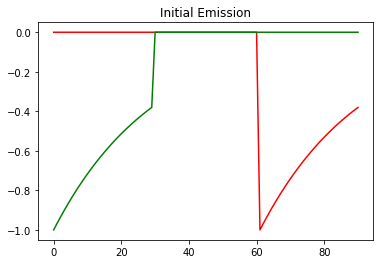

In [17]:
plt.figure()
plt.title("Initial Emission")
plt.plot(range(0, 91), estimator.emit_w_init_[0, 0, :], "-r")
plt.plot(range(0, 91), estimator.emit_w_init_[1, 0, :], "-g")
plt.show()

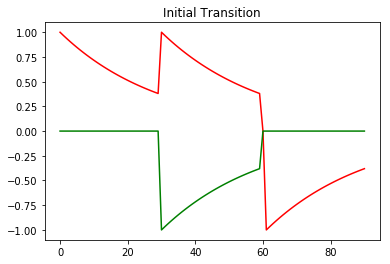

In [18]:
plt.figure()
plt.title("Initial Transition")
plt.plot(range(0, 91), estimator.trans_w_init_[0, 1, :], "-r")
plt.plot(range(0, 91), estimator.trans_w_init_[1, 0, :], "-g")
plt.show()

In [19]:
emit_w_final = output[-1]['emit_w']
trans_w_final = output[-1]['trans_w']

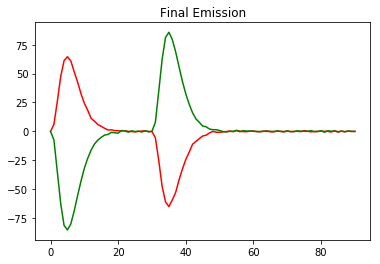

In [20]:
plt.figure()
plt.title("Final Emission")
plt.plot(range(0, 91), emit_w_final[0, 0, :], "-r")
plt.plot(range(0, 91), emit_w_final[1, 0, :], "-g")
plt.show()

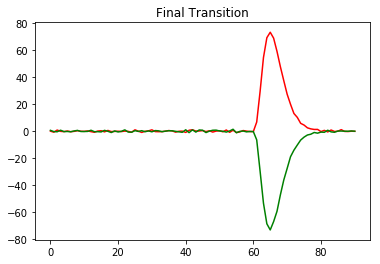

In [21]:
plt.figure()
plt.title("Final Transition")
plt.plot(range(0, 91), trans_w_final[0, 1, :], "-r")
plt.plot(range(0, 91), trans_w_final[1, 0, :], "-g")
plt.show()